In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool
from category_encoders import CatBoostEncoder
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [4]:
num = ['child_num', 'income_total', 'DAYS_BIRTH','DAYS_EMPLOYED', 'family_size', 'begin_month']
cat = ['gender', 'car', 'reality','income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email','occyp_type']

In [5]:
# index(인덱스번호), FLAG_MOBIL(핸드폰 소유 여부) 컬럼 삭제

train = train.drop(columns = ['index', 'FLAG_MOBIL'])
test = test.drop(columns = ['index', 'FLAG_MOBIL'])

## <font color = mediumblue> ** 결측치 처리 **

In [6]:
# 고용되지 않은 사람 -> 'unemployed'로 처리

train.loc[train['DAYS_EMPLOYED'] > 0,'occyp_type'] = 'unemployed'
test.loc[test['DAYS_EMPLOYED'] > 0,'occyp_type'] = 'unemployed'

In [7]:
train = train.fillna('NaN')
test = test.fillna('NaN')

## <font color = mediumblue> ** 이상치 처리 **

#### ID 열 생성

In [8]:
info = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type','edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED','work_phone', 'phone', 'email', 'occyp_type', 'family_size']

train_customer = train.drop_duplicates(info)

train_customer.insert(0, 'ID', np.arange(0, len(train_customer)))
train_customer = train_customer.drop(columns=['begin_month', 'credit'])

train = pd.merge(train_customer, train , how='right', on=info)

test_customer = test.drop_duplicates(info)

test_customer.insert(0, 'ID', np.arange(0, len(test_customer)))
test_customer = test_customer.drop(columns=['begin_month'])

test = pd.merge(test_customer, test , how='right', on=info)

####  DAYS_BIRTH ,  begin_month

In [9]:
# 음수 -> 양수로 변환

train['DAYS_BIRTH'] = train['DAYS_BIRTH'] * -1
test['DAYS_BIRTH'] = test['DAYS_BIRTH'] * -1

train['begin_month'] = train['begin_month'] * -1
test['begin_month'] = test['begin_month'] * -1

#### DAYS_EMPLOYED 

In [10]:
# 고용되지 않은 사람 0으로 처리

train.loc[train['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = 0

In [11]:
# 음수 -> 양수로 변환

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'] * -1
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'] * -1

#### 표준화한 값의 절댓값이 3이상인 데이터 대체

In [12]:
train[num].describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,15958.053899,2198.529538,2.196848,26.123294
std,0.747326,1.018784e+05,4201.589022,2370.140530,0.916717,16.559550
min,0.000000,2.700000e+04,7705.000000,0.000000,1.000000,-0.000000
25%,0.000000,1.215000e+05,12446.000000,407.000000,2.000000,12.000000
50%,0.000000,1.575000e+05,15547.000000,1539.000000,2.000000,24.000000
75%,1.000000,2.250000e+05,19431.000000,3153.000000,3.000000,39.000000
max,19.000000,1.575000e+06,25152.000000,15713.000000,20.000000,60.000000


In [13]:
# 표준화한 값의 절댓값이 3 이상인 데이터를 clip을 활용해 대체하는 함수

def z_score_outlier(col):
    
    n_std =  np.std(train[col])
    n_mean = np.mean(train[col])
    
    upper = (3*n_std) + n_mean # 표준화 했을 때의 값이 3
    lower = ((-3)*n_std) + n_mean # 표준화 했을 때의 값이 -3
    
    train[col] = train[col].clip(lower=lower, upper=upper)
    test[col] = test[col].clip(lower=lower, upper=upper)

In [14]:
# 함수에 적용

z_score_outlier('income_total')

In [15]:
pd.DataFrame(train.groupby('family_size')['credit'].mean()).sort_values(by='family_size')

,credit
family_size,
1.0,1.505187
2.0,1.525805
3.0,1.501727
4.0,1.547788
5.0,1.560137
6.0,1.409091
7.0,0.888889
9.0,2.000000
15.0,2.000000


In [16]:
pd.DataFrame(train.groupby('child_num')['credit'].mean()).sort_values(by='child_num')

,credit
child_num,
0,1.520829
1,1.502971
2,1.546571
3,1.552288
4,1.404255
5,1.000000
7,2.000000
14,2.000000
19,2.000000


In [17]:
# child_num, family_size일정수치 이상은 같은 credit값 가지므로 하나로 치환

train.child_num = train.child_num.clip(upper=6)
test.child_num = test.child_num.clip(upper=6)

train.family_size = train.family_size.clip(upper=8)
test.family_size = test.family_size.clip(upper=8)

In [18]:
train[num].describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
count,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.427184,184830.586410,15958.053899,2198.529538,2.195525,26.123294
std,0.726875,89387.516632,4201.589022,2370.140530,0.902185,16.559550
min,0.000000,27000.000000,7705.000000,0.000000,1.000000,-0.000000
25%,0.000000,121500.000000,12446.000000,407.000000,2.000000,12.000000
50%,0.000000,157500.000000,15547.000000,1539.000000,2.000000,24.000000
75%,1.000000,225000.000000,19431.000000,3153.000000,3.000000,39.000000
max,6.000000,492935.852351,25152.000000,15713.000000,8.000000,60.000000


## <font color = mediumblue> ** Feature 생성 **

In [19]:
train.head()

,ID,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0


<font color = 'navy'>**income/family** <font color = 'black'>-> 평균 소득

In [20]:
train['income/family'] = train['income_total'] / (train['family_size']+1)
test['income/family'] = test['income_total'] / (test['family_size']+1)

 <font color = 'navy'> **adult_num** <font color = 'black'> -> 어른 수

In [21]:
train['adult_num'] = train['family_size'] - train['child_num']
test['adult_num'] = test['family_size'] - test['child_num']

<font color = 'navy'>**age** <font color = 'black'>-> 나이

In [22]:
train['age'] = train['DAYS_BIRTH'] // 365
test['age'] = test['DAYS_BIRTH'] // 365

 <font color = 'navy'> **EMPLOYED** -> <font color = 'black'>업무 시작 여부

In [23]:
train['EMPLOYED'] = 0
test['EMPLOYED'] = 0

train.loc[train['DAYS_EMPLOYED'] > 0, 'EMPLOYED'] = 1
test.loc[test['DAYS_EMPLOYED'] > 0, 'EMPLOYED'] = 1

<font color = 'navy'> **MONTH_EMPLOYED**  <font color = 'black'> -> 고용된 지 몇 달 지났는지

In [24]:
train['MONTH_EMPLOYED'] = train['DAYS_EMPLOYED'] // 30
test['MONTH_EMPLOYED'] = test['DAYS_EMPLOYED'] // 30

 <font color = 'navy'> **YEAR_EMPLOYED**  <font color = 'black'> -> 고용된 지 몇 년 지났는 지

In [25]:
train['YEAR_EMPLOYED'] = train['DAYS_EMPLOYED'] // 365
test['YEAR_EMPLOYED'] = test['DAYS_EMPLOYED'] // 365

<font color = 'navy'> **YEAR_EMPLOYED_q** <font color = 'black'> -> YEAR_EMPLOYED_q 사분위

In [26]:
q1, q2, q3 = train['YEAR_EMPLOYED'].quantile([0.25, 0.5, 0.75])

train['YEAR_EMPLOYED_q'] = train['YEAR_EMPLOYED'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)
test['YEAR_EMPLOYED_q'] = test['YEAR_EMPLOYED'].apply(lambda x: 0 if x<q1 else 1 if x<q2 else 2 if x<q3 else 3)

 <font color = 'navy'> **DAYS_UNEMPLOYED** <font color = 'black'> -> 고용되기 시작한 일

In [27]:
train['DAYS_UNEMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
test['DAYS_UNEMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

<font color = 'navy'> **GCR** <font color = 'black'> ->  gender, car, reality 합친 범주

In [28]:
train['GCR'] = train.gender + train.car + train.reality
test['GCR'] = test.gender + test.car+ test.reality

<font color = 'navy'> **WPE** <font color = 'black'> -> work_phone, phone, email 열 더한 feature

In [29]:
train['WPE'] = train.work_phone + train.phone + train.email
test['WPE'] = test.work_phone + test.phone + test.email

<font color = 'navy'> **reality_house** <font color = 'black'> -> reality, house type 문자열로 연결하여 부동산 소유여부, 생활방식 합친 feature

In [30]:
train['reality_house'] = train.reality +'_'+ train.house_type
test['reality_house'] = test.reality +'_'+ test.house_type

 <font color = 'navy'> **income_month** <font color = 'black'> -> 월 소득

In [31]:
train['income_month'] = train['income_total'] / 12
test['income_month'] = test['income_total'] / 12

<font color = 'navy'> **all_income** <font color = 'black'>  -> 총 소득

In [32]:
train['all_income'] = train['income_total'] * train['YEAR_EMPLOYED']
test['all_income'] = test['income_total'] * test['YEAR_EMPLOYED']

<font color = 'navy'> **begin_year** <font color = 'black'> -> 신용카드 발급한 지 몇 년 지났는지

In [33]:
train['begin_year'] = train['begin_month'] // 12
test['begin_year'] = test['begin_month'] // 12

<font color = 'navy'> **income_changed** -> <font color = 'black'> 소득 변화 여부

MONTH_EMPLOYED > begin_month -> 소득변화가 없었음<br>
MONTH_EMPLOYED < begin_month -> 소득변화가 있었음

In [34]:
train['income_changed'] = 0
test['income_changed'] = 0

train.loc[train['MONTH_EMPLOYED'] < train['begin_month'], 'income_changed'] = 1
test.loc[test['MONTH_EMPLOYED'] < test['begin_month'], 'income_changed'] = 1

## 피처 중요도가 높은 순으로의 또 다른 피처 생성

<font color = 'navy'> **출생일 범주화**

In [35]:
train['나이_실수ver']= train['DAYS_BIRTH']/365
test['나이_실수ver']= test['DAYS_BIRTH']/365

In [36]:
def age_bumju(x):
    if 0<x<20:
        x= 0
    elif 20<= x<30:
        x=1
    elif 30<=x<40:
        x=2
    elif 40<=x<50:
        x=3
    elif 50<=x<60:
        x=4
    elif 60<=x<70:
        x=5
    else:
        x=6
    return x
train['나이_범주화']= train['나이_실수ver'].apply(age_bumju)
test['나이_범주화']= test['나이_실수ver'].apply(age_bumju)

<font color='navy'> **고용된 나이 4분위**

In [37]:
q1,q2,q3= train['DAYS_UNEMPLOYED'].quantile([0.25,0.5,0.75])

train['DAYS_UNEMPLOYED_4']= train['DAYS_UNEMPLOYED'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)
test['DAYS_UNEMPLOYED_4']= test['DAYS_UNEMPLOYED'].apply(lambda x: 0 if x<=q1 else 1 if x<=q2 else 2 if x<=q3 else 3)

<font color= 'navy'> **중요도가 높은 것끼리의 곱**

In [38]:
train['고용중x평균소득']= train['DAYS_EMPLOYED']* train['income/family']
test['고용중x평균소득']= test['DAYS_EMPLOYED']* test['income/family']

train['고용중x총소득']= train['DAYS_EMPLOYED']* train['income_total']
test['고용중x총소득']= test['DAYS_EMPLOYED']* test['income_total']

train['고용중xbirth']= train['DAYS_EMPLOYED']* train['DAYS_BIRTH']
test['고용중xbirth']= test['DAYS_EMPLOYED']* test['DAYS_BIRTH']

train['고용중xemploy']= train['DAYS_EMPLOYED']* train['DAYS_UNEMPLOYED']
test['고용중xemploy']= test['DAYS_EMPLOYED']* test['DAYS_UNEMPLOYED']

In [39]:
train['unemploy*birth']= train['DAYS_UNEMPLOYED']*train['DAYS_BIRTH']
test['unemploy*birth']= test['DAYS_UNEMPLOYED']*test['DAYS_BIRTH']

train['unemploy*income/family']= train['DAYS_UNEMPLOYED']*train['income/family']
test['unemploy*income/family']= test['DAYS_UNEMPLOYED']*test['income/family']

train['unemploy*employ']= train['DAYS_UNEMPLOYED']*train['DAYS_EMPLOYED']
test['unemploy*employ']= test['DAYS_UNEMPLOYED']*test['DAYS_EMPLOYED']

train['unemploy*income_total']=train['DAYS_UNEMPLOYED']*train['income_total']
test['unemploy*income_total']=test['DAYS_UNEMPLOYED']*test['income_total']

<font color = 'navy'> **groupby 범주, 수치 열 생성**

- income type 기준

In [40]:
#total_income
income_mean_income = dict(train.groupby('income_type')['income_total'].mean())

train['income_mean_income'] = train['income_type'].apply(lambda x: income_mean_income[x])
test['income_mean_income'] = test['income_type'].apply(lambda x: income_mean_income[x])

income_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['income_sum_income'] = train['income_type'].apply(lambda x: income_sum_income[x])
test['income_sum_income'] = test['income_type'].apply(lambda x: income_sum_income[x])

income_std_income = dict(train.groupby('income_type')['income_total'].std())

train['income_std_income'] = train['income_type'].apply(lambda x: income_std_income[x])
test['income_std_income'] = test['income_type'].apply(lambda x: income_std_income[x])

In [41]:
#child_num
child_mean_income = train.groupby('income_type')['child_num'].mean()
train['child_mean_income'] = train['income_type'].apply(lambda x: child_mean_income[x])
test['child_mean_income'] = test['income_type'].apply(lambda x: child_mean_income[x])

child_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['child_sum_income'] = train['income_type'].apply(lambda x: child_sum_income[x])
test['child_sum_income'] = test['income_type'].apply(lambda x: child_sum_income[x])

child_std_income = dict(train.groupby('income_type')['income_total'].std())

train['child_std_income'] = train['income_type'].apply(lambda x: child_std_income[x])
test['child_std_income'] = test['income_type'].apply(lambda x: child_std_income[x])

In [42]:
#age
age_mean_income = train.groupby('income_type')['age'].mean()
train['age_mean_income'] = train['income_type'].apply(lambda x: age_mean_income[x])
test['age_mean_income'] = test['income_type'].apply(lambda x: age_mean_income[x])

age_sum_income = dict(train.groupby('income_type')['income_total'].sum())

train['age_sum_income'] = train['income_type'].apply(lambda x: age_sum_income[x])
test['age_sum_income'] = test['income_type'].apply(lambda x: age_sum_income[x])

age_std_income = dict(train.groupby('income_type')['income_total'].std())

train['age_std_income'] = train['income_type'].apply(lambda x: age_std_income[x])
test['age_std_income'] = test['income_type'].apply(lambda x: age_std_income[x])

In [43]:
#YEAR_EMPLOYED
EMPLOYED_mean_income = train.groupby('income_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_income'] = train['income_type'].apply(lambda x: EMPLOYED_mean_income[x])
test['EMPLOYED_mean_income'] = test['income_type'].apply(lambda x: EMPLOYED_mean_income[x])

EMPLOYED_sum_income = dict(train.groupby('income_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_income'] = train['income_type'].apply(lambda x: EMPLOYED_sum_income[x])
test['EMPLOYED_sum_income'] = test['income_type'].apply(lambda x: EMPLOYED_sum_income[x])

EMPLOYED_std_income = dict(train.groupby('income_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_income'] = train['income_type'].apply(lambda x: EMPLOYED_std_income[x])
test['EMPLOYED_std_income'] = test['income_type'].apply(lambda x: EMPLOYED_std_income[x])

- edu_type

In [44]:
#income_total
income_mean_edu = dict(train.groupby('edu_type')['income_total'].mean())

train['income_mean_edu'] = train['edu_type'].apply(lambda x: income_mean_edu[x])
test['income_mean_edu'] = test['edu_type'].apply(lambda x: income_mean_edu[x])

income_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['income_sum_edu'] = train['edu_type'].apply(lambda x: income_sum_edu[x])
test['income_sum_edu'] = test['edu_type'].apply(lambda x: income_sum_edu[x])

income_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['income_std_edu'] = train['edu_type'].apply(lambda x: income_std_edu[x])
test['income_std_edu'] = test['edu_type'].apply(lambda x: income_std_edu[x])

In [45]:
#child_num
child_mean_edu = train.groupby('edu_type')['child_num'].mean()
train['child_mean_edu'] = train['edu_type'].apply(lambda x: child_mean_edu[x])
test['child_mean_edu'] = test['edu_type'].apply(lambda x: child_mean_edu[x])

child_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['child_sum_edu'] = train['edu_type'].apply(lambda x: child_sum_edu[x])
test['child_sum_edu'] = test['edu_type'].apply(lambda x: child_sum_edu[x])

child_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['child_std_edu'] = train['edu_type'].apply(lambda x: child_std_edu[x])
test['child_std_edu'] = test['edu_type'].apply(lambda x: child_std_edu[x])

In [46]:
#age
age_mean_edu = train.groupby('edu_type')['age'].mean()
train['age_mean_edu'] = train['edu_type'].apply(lambda x: age_mean_edu[x])
test['age_mean_edu'] = test['edu_type'].apply(lambda x: age_mean_edu[x])

age_sum_edu = dict(train.groupby('edu_type')['income_total'].sum())

train['age_sum_edu'] = train['edu_type'].apply(lambda x: age_sum_edu[x])
test['age_sum_edu'] = test['edu_type'].apply(lambda x: age_sum_edu[x])

age_std_edu = dict(train.groupby('edu_type')['income_total'].std())

train['age_std_edu'] = train['edu_type'].apply(lambda x: age_std_edu[x])
test['age_std_edu'] = test['edu_type'].apply(lambda x: age_std_edu[x])

In [47]:
#YEARS_EMPLOYED
EMPLOYED_mean_edu = train.groupby('edu_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_mean_edu[x])
test['EMPLOYED_mean_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_mean_edu[x])

EMPLOYED_sum_edu = dict(train.groupby('edu_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_sum_edu[x])
test['EMPLOYED_sum_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_sum_edu[x])

EMPLOYED_std_edu = dict(train.groupby('edu_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_edu'] = train['edu_type'].apply(lambda x: EMPLOYED_std_edu[x])
test['EMPLOYED_std_edu'] = test['edu_type'].apply(lambda x: EMPLOYED_std_edu[x])

- house type

In [48]:
#income_total
income_mean_house = dict(train.groupby('house_type')['income_total'].mean())

train['income_mean_house'] = train['house_type'].apply(lambda x: income_mean_house[x])
test['income_mean_house'] = test['house_type'].apply(lambda x: income_mean_house[x])

income_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['income_sum_house'] = train['house_type'].apply(lambda x: income_sum_house[x])
test['income_sum_house'] = test['house_type'].apply(lambda x: income_sum_house[x])

income_std_house = dict(train.groupby('house_type')['income_total'].std())

train['income_std_house'] = train['house_type'].apply(lambda x: income_std_house[x])
test['income_std_house'] = test['house_type'].apply(lambda x: income_std_house[x])

In [49]:
#child_num
child_mean_house = train.groupby('house_type')['child_num'].mean()
train['child_mean_house'] = train['house_type'].apply(lambda x: child_mean_house[x])
test['child_mean_house'] = test['house_type'].apply(lambda x: child_mean_house[x])

child_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['child_sum_house'] = train['house_type'].apply(lambda x: child_sum_house[x])
test['child_sum_house'] = test['house_type'].apply(lambda x: child_sum_house[x])

child_std_house = dict(train.groupby('house_type')['income_total'].std())

train['child_std_house'] = train['house_type'].apply(lambda x: child_std_house[x])
test['child_std_house'] = test['house_type'].apply(lambda x: child_std_house[x])

In [50]:
#age
age_mean_house = train.groupby('house_type')['age'].mean()
train['age_mean_house'] = train['house_type'].apply(lambda x: age_mean_house[x])
test['age_mean_house'] = test['house_type'].apply(lambda x: age_mean_house[x])

age_sum_house = dict(train.groupby('house_type')['income_total'].sum())

train['age_sum_house'] = train['house_type'].apply(lambda x: age_sum_house[x])
test['age_sum_house'] = test['house_type'].apply(lambda x: age_sum_house[x])

age_std_house = dict(train.groupby('house_type')['income_total'].std())

train['age_std_house'] = train['house_type'].apply(lambda x: age_std_house[x])
test['age_std_house'] = test['house_type'].apply(lambda x: age_std_house[x])

In [51]:
#YEARS_EMPLOYED
EMPLOYED_mean_house = train.groupby('house_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_house'] = train['house_type'].apply(lambda x: EMPLOYED_mean_house[x])
test['EMPLOYED_mean_house'] = test['house_type'].apply(lambda x: EMPLOYED_mean_house[x])

EMPLOYED_sum_house = dict(train.groupby('house_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_house'] = train['house_type'].apply(lambda x: EMPLOYED_sum_house[x])
test['EMPLOYED_sum_house'] = test['house_type'].apply(lambda x: EMPLOYED_sum_house[x])

EMPLOYED_std_house = dict(train.groupby('house_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_house'] = train['house_type'].apply(lambda x: EMPLOYED_std_house[x])
test['EMPLOYED_std_house'] = test['house_type'].apply(lambda x: EMPLOYED_std_house[x])

- family type

In [52]:
#income_total
income_mean_family = dict(train.groupby('family_type')['income_total'].mean())

train['income_mean_family'] = train['family_type'].apply(lambda x: income_mean_family[x])
test['income_mean_family'] = test['family_type'].apply(lambda x: income_mean_family[x])

income_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['income_sum_family'] = train['family_type'].apply(lambda x: income_sum_family[x])
test['income_sum_family'] = test['family_type'].apply(lambda x: income_sum_family[x])

income_std_family = dict(train.groupby('family_type')['income_total'].std())

train['income_std_family'] = train['family_type'].apply(lambda x: income_std_family[x])
test['income_std_family'] = test['family_type'].apply(lambda x: income_std_family[x])

In [53]:
#child_num
child_mean_family = train.groupby('family_type')['child_num'].mean()
train['child_mean_family'] = train['family_type'].apply(lambda x: child_mean_family[x])
test['child_mean_family'] = test['family_type'].apply(lambda x: child_mean_family[x])

child_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['child_sum_family'] = train['family_type'].apply(lambda x: child_sum_family[x])
test['child_sum_family'] = test['family_type'].apply(lambda x: child_sum_family[x])

child_std_family = dict(train.groupby('family_type')['income_total'].std())

train['child_std_family'] = train['family_type'].apply(lambda x: child_std_family[x])
test['child_std_family'] = test['family_type'].apply(lambda x: child_std_family[x])

In [54]:
#age
age_mean_family = train.groupby('family_type')['age'].mean()
train['age_mean_family'] = train['family_type'].apply(lambda x: age_mean_family[x])
test['age_mean_family'] = test['family_type'].apply(lambda x: age_mean_family[x])

age_sum_family = dict(train.groupby('family_type')['income_total'].sum())

train['age_sum_family'] = train['family_type'].apply(lambda x: age_sum_family[x])
test['age_sum_family'] = test['family_type'].apply(lambda x: age_sum_family[x])

age_std_family = dict(train.groupby('family_type')['income_total'].std())

train['age_std_family'] = train['family_type'].apply(lambda x: age_std_family[x])
test['age_std_family'] = test['family_type'].apply(lambda x: age_std_family[x])

In [55]:
#YEARS_EMPLOYED
EMPLOYED_mean_family = train.groupby('family_type')['YEAR_EMPLOYED'].mean()

train['EMPLOYED_mean_family'] = train['family_type'].apply(lambda x: EMPLOYED_mean_family[x])
test['EMPLOYED_mean_family'] = test['family_type'].apply(lambda x: EMPLOYED_mean_family[x])

EMPLOYED_sum_family = dict(train.groupby('family_type')['YEAR_EMPLOYED'].sum())

train['EMPLOYED_sum_family'] = train['family_type'].apply(lambda x: EMPLOYED_sum_family[x])
test['EMPLOYED_sum_family'] = test['family_type'].apply(lambda x: EMPLOYED_sum_family[x])

EMPLOYED_std_family = dict(train.groupby('family_type')['YEAR_EMPLOYED'].std())

train['EMPLOYED_std_family'] = train['family_type'].apply(lambda x: EMPLOYED_std_family[x])
test['EMPLOYED_std_family'] = test['family_type'].apply(lambda x: EMPLOYED_std_family[x])

## <font color = mediumblue> ** Scaling **

In [56]:
num = ['child_num', 'income_total', 'DAYS_BIRTH','DAYS_EMPLOYED', 'family_size',  'begin_month', 'income/family', 'adult_num', 'age', 'MONTH_EMPLOYED', 'YEAR_EMPLOYED',
       'DAYS_UNEMPLOYED', 'WPE', 'income_month', 'all_income','begin_year','income_mean_income', 'income_sum_income', 'income_std_income',
       'child_mean_income', 'child_sum_income', 'child_std_income',
       'age_mean_income', 'age_sum_income', 'age_std_income',
       'EMPLOYED_mean_income', 'EMPLOYED_sum_income', 'EMPLOYED_std_income',
       'income_mean_edu', 'income_sum_edu', 'income_std_edu', 'child_mean_edu',
       'child_sum_edu', 'child_std_edu', 'age_mean_edu', 'age_sum_edu',
       'age_std_edu', 'EMPLOYED_mean_edu', 'EMPLOYED_sum_edu',
       'EMPLOYED_std_edu', 'income_mean_house', 'income_sum_house',
       'income_std_house', 'child_mean_house', 'child_sum_house',
       'child_std_house', 'age_mean_house', 'age_sum_house', 'age_std_house',
       'EMPLOYED_mean_house', 'EMPLOYED_sum_house', 'EMPLOYED_std_house',
       'income_mean_family', 'income_sum_family', 'income_std_family',
       'child_mean_family', 'child_sum_family', 'child_std_family',
       'age_mean_family', 'age_sum_family', 'age_std_family',
       'EMPLOYED_mean_family', 'EMPLOYED_sum_family', 'EMPLOYED_std_family',
       '나이_실수ver','고용중x평균소득','고용중x총소득',
       '고용중xbirth','고용중xemploy','unemploy*birth','unemploy*income/family','unemploy*employ','unemploy*income_total']

cat = ['ID', 'gender', 'car', 'reality','income_type', 'edu_type', 'family_type',
       'house_type', 'work_phone', 'phone', 'email','occyp_type', 'EMPLOYED', 'YEAR_EMPLOYED_q',
       'GCR', 'reality_house', 'income_changed', '나이_범주화','DAYS_UNEMPLOYED_4']

#### - MinMaxScaler -

In [57]:
scaler = MinMaxScaler()
train[num] = scaler.fit_transform(train[num])
test[num] = scaler.transform(test[num])

#### - 로그변환 -

In [58]:
train[num] = np.log1p(train[num])
test[num] = np.log1p(test[num])

## <font color = mediumblue> ** Encoding **

#### - binary encoding -

In [59]:
train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0)
test['gender'] = test['gender'].apply(lambda x: 1 if x=='M' else 0)

train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0)
test['car'] = test['car'].apply(lambda x: 1 if x=='Y' else 0)

train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0)
test['reality'] = test['reality'].apply(lambda x: 1 if x=='Y' else 0)

#### - Ordinary encoding -

In [60]:
train.loc[train['edu_type'] == 'Lower secondary', 'edu_type'] = 0
train.loc[train['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 1
train.loc[train['edu_type'] == 'Incomplete higher', 'edu_type'] = 2
train.loc[train['edu_type'] == 'Higher education', 'edu_type'] = 3
train.loc[train['edu_type'] == 'Academic degree', 'edu_type'] = 4

test.loc[test['edu_type'] == 'Lower secondary', 'edu_type'] = 0
test.loc[test['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 1
test.loc[test['edu_type'] == 'Incomplete higher', 'edu_type'] = 2
test.loc[test['edu_type'] == 'Higher education', 'edu_type'] = 3
test.loc[test['edu_type'] == 'Academic degree', 'edu_type'] = 4

In [61]:
train['edu_type']=train['edu_type'].astype('int')
test['edu_type']=test['edu_type'].astype('int')

#### - Label encoding -

In [62]:
# Label Encoding 할 feature들

label_col = ['ID', 'income_type', 'family_type', 'house_type', 'occyp_type', 'GCR', 'reality_house']

In [63]:
for col in label_col:
    lbencoder = LabelEncoder()
    lbencoder.fit(train[col])
    train[col] = lbencoder.transform(train[col])
    test[col] = lbencoder.transform(test[col])

## <font color = mediumblue> ** Feature Selection **

In [64]:
train_X = train.drop(columns='credit')
train_y = train['credit']

#### - Feature Importance -

In [65]:
selector = SelectFromModel(CatBoostClassifier(random_state=0, cat_features=cat), threshold=None)
fs = selector.fit(train_X, train_y).transform(train_X)

mask = selector.get_support()

fs_dict = {}
for i in range(len(train_X.columns)):
    fs_dict[train_X.columns[i]] = mask[i]

Learning rate set to 0.093513
0:	learn: 1.0462289	total: 278ms	remaining: 4m 38s
1:	learn: 1.0049981	total: 362ms	remaining: 3m
2:	learn: 0.9715415	total: 585ms	remaining: 3m 14s
3:	learn: 0.9443407	total: 680ms	remaining: 2m 49s
4:	learn: 0.9221418	total: 995ms	remaining: 3m 18s
5:	learn: 0.9036928	total: 1.27s	remaining: 3m 29s
6:	learn: 0.8885351	total: 1.36s	remaining: 3m 13s
7:	learn: 0.8767118	total: 1.56s	remaining: 3m 13s
8:	learn: 0.8660199	total: 1.76s	remaining: 3m 13s
9:	learn: 0.8568534	total: 2.07s	remaining: 3m 24s
10:	learn: 0.8493019	total: 2.14s	remaining: 3m 12s
11:	learn: 0.8283998	total: 2.35s	remaining: 3m 13s
12:	learn: 0.8112558	total: 2.52s	remaining: 3m 11s
13:	learn: 0.7979681	total: 2.74s	remaining: 3m 13s
14:	learn: 0.7859535	total: 2.92s	remaining: 3m 11s
15:	learn: 0.7762591	total: 3.13s	remaining: 3m 12s
16:	learn: 0.7685614	total: 3.32s	remaining: 3m 12s
17:	learn: 0.7618068	total: 3.52s	remaining: 3m 12s
18:	learn: 0.7564277	total: 3.7s	remaining: 3m 1

159:	learn: 0.6943622	total: 35.2s	remaining: 3m 5s
160:	learn: 0.6942607	total: 35.5s	remaining: 3m 4s
161:	learn: 0.6940632	total: 35.7s	remaining: 3m 4s
162:	learn: 0.6939225	total: 35.9s	remaining: 3m 4s
163:	learn: 0.6937858	total: 36.1s	remaining: 3m 4s
164:	learn: 0.6936797	total: 36.3s	remaining: 3m 3s
165:	learn: 0.6936477	total: 36.5s	remaining: 3m 3s
166:	learn: 0.6935375	total: 36.8s	remaining: 3m 3s
167:	learn: 0.6934552	total: 37s	remaining: 3m 3s
168:	learn: 0.6932495	total: 37.2s	remaining: 3m 3s
169:	learn: 0.6932050	total: 37.5s	remaining: 3m 2s
170:	learn: 0.6931630	total: 37.7s	remaining: 3m 2s
171:	learn: 0.6929373	total: 37.9s	remaining: 3m 2s
172:	learn: 0.6928408	total: 38.2s	remaining: 3m 2s
173:	learn: 0.6927448	total: 38.4s	remaining: 3m 2s
174:	learn: 0.6925607	total: 38.7s	remaining: 3m 2s
175:	learn: 0.6924150	total: 38.9s	remaining: 3m 2s
176:	learn: 0.6922773	total: 39.1s	remaining: 3m 1s
177:	learn: 0.6922061	total: 39.3s	remaining: 3m 1s
178:	learn: 0.

316:	learn: 0.6741817	total: 1m 10s	remaining: 2m 31s
317:	learn: 0.6740542	total: 1m 10s	remaining: 2m 30s
318:	learn: 0.6739975	total: 1m 10s	remaining: 2m 30s
319:	learn: 0.6739338	total: 1m 10s	remaining: 2m 30s
320:	learn: 0.6738490	total: 1m 10s	remaining: 2m 30s
321:	learn: 0.6737482	total: 1m 11s	remaining: 2m 29s
322:	learn: 0.6735875	total: 1m 11s	remaining: 2m 29s
323:	learn: 0.6734625	total: 1m 11s	remaining: 2m 29s
324:	learn: 0.6733207	total: 1m 11s	remaining: 2m 29s
325:	learn: 0.6731632	total: 1m 12s	remaining: 2m 28s
326:	learn: 0.6729238	total: 1m 12s	remaining: 2m 28s
327:	learn: 0.6728307	total: 1m 12s	remaining: 2m 28s
328:	learn: 0.6727021	total: 1m 12s	remaining: 2m 28s
329:	learn: 0.6725150	total: 1m 12s	remaining: 2m 28s
330:	learn: 0.6723141	total: 1m 13s	remaining: 2m 27s
331:	learn: 0.6720978	total: 1m 13s	remaining: 2m 27s
332:	learn: 0.6720053	total: 1m 13s	remaining: 2m 27s
333:	learn: 0.6719481	total: 1m 13s	remaining: 2m 27s
334:	learn: 0.6717540	total:

469:	learn: 0.6556776	total: 1m 44s	remaining: 1m 58s
470:	learn: 0.6555221	total: 1m 45s	remaining: 1m 58s
471:	learn: 0.6554053	total: 1m 45s	remaining: 1m 57s
472:	learn: 0.6552987	total: 1m 45s	remaining: 1m 57s
473:	learn: 0.6552014	total: 1m 46s	remaining: 1m 57s
474:	learn: 0.6551139	total: 1m 46s	remaining: 1m 57s
475:	learn: 0.6549800	total: 1m 46s	remaining: 1m 57s
476:	learn: 0.6549061	total: 1m 47s	remaining: 1m 57s
477:	learn: 0.6546513	total: 1m 47s	remaining: 1m 57s
478:	learn: 0.6545296	total: 1m 47s	remaining: 1m 57s
479:	learn: 0.6544577	total: 1m 48s	remaining: 1m 57s
480:	learn: 0.6543959	total: 1m 48s	remaining: 1m 57s
481:	learn: 0.6541303	total: 1m 48s	remaining: 1m 56s
482:	learn: 0.6539684	total: 1m 49s	remaining: 1m 56s
483:	learn: 0.6538980	total: 1m 49s	remaining: 1m 56s
484:	learn: 0.6538040	total: 1m 49s	remaining: 1m 56s
485:	learn: 0.6536111	total: 1m 50s	remaining: 1m 56s
486:	learn: 0.6534455	total: 1m 50s	remaining: 1m 56s
487:	learn: 0.6532278	total:

622:	learn: 0.6367708	total: 2m 22s	remaining: 1m 26s
623:	learn: 0.6366421	total: 2m 22s	remaining: 1m 26s
624:	learn: 0.6365632	total: 2m 23s	remaining: 1m 25s
625:	learn: 0.6364872	total: 2m 23s	remaining: 1m 25s
626:	learn: 0.6363728	total: 2m 24s	remaining: 1m 25s
627:	learn: 0.6363444	total: 2m 24s	remaining: 1m 25s
628:	learn: 0.6363053	total: 2m 24s	remaining: 1m 25s
629:	learn: 0.6362321	total: 2m 25s	remaining: 1m 25s
630:	learn: 0.6361026	total: 2m 25s	remaining: 1m 25s
631:	learn: 0.6360045	total: 2m 25s	remaining: 1m 24s
632:	learn: 0.6359577	total: 2m 25s	remaining: 1m 24s
633:	learn: 0.6357708	total: 2m 26s	remaining: 1m 24s
634:	learn: 0.6357090	total: 2m 26s	remaining: 1m 24s
635:	learn: 0.6356157	total: 2m 26s	remaining: 1m 23s
636:	learn: 0.6354844	total: 2m 26s	remaining: 1m 23s
637:	learn: 0.6353537	total: 2m 27s	remaining: 1m 23s
638:	learn: 0.6352118	total: 2m 27s	remaining: 1m 23s
639:	learn: 0.6351092	total: 2m 27s	remaining: 1m 23s
640:	learn: 0.6350233	total:

776:	learn: 0.6194239	total: 2m 59s	remaining: 51.6s
777:	learn: 0.6192567	total: 3m	remaining: 51.4s
778:	learn: 0.6191665	total: 3m	remaining: 51.1s
779:	learn: 0.6190421	total: 3m	remaining: 50.9s
780:	learn: 0.6189285	total: 3m	remaining: 50.7s
781:	learn: 0.6188529	total: 3m	remaining: 50.4s
782:	learn: 0.6187816	total: 3m 1s	remaining: 50.2s
783:	learn: 0.6186401	total: 3m 1s	remaining: 49.9s
784:	learn: 0.6184507	total: 3m 1s	remaining: 49.7s
785:	learn: 0.6182900	total: 3m 1s	remaining: 49.5s
786:	learn: 0.6182104	total: 3m 1s	remaining: 49.2s
787:	learn: 0.6180997	total: 3m 2s	remaining: 49s
788:	learn: 0.6179338	total: 3m 2s	remaining: 48.7s
789:	learn: 0.6178018	total: 3m 2s	remaining: 48.5s
790:	learn: 0.6176452	total: 3m 2s	remaining: 48.3s
791:	learn: 0.6176050	total: 3m 2s	remaining: 48s
792:	learn: 0.6174511	total: 3m 3s	remaining: 47.8s
793:	learn: 0.6172451	total: 3m 3s	remaining: 47.6s
794:	learn: 0.6170692	total: 3m 3s	remaining: 47.3s
795:	learn: 0.6169675	total: 3

933:	learn: 0.6011771	total: 3m 44s	remaining: 15.8s
934:	learn: 0.6010178	total: 3m 44s	remaining: 15.6s
935:	learn: 0.6009247	total: 3m 44s	remaining: 15.4s
936:	learn: 0.6008416	total: 3m 45s	remaining: 15.1s
937:	learn: 0.6007238	total: 3m 45s	remaining: 14.9s
938:	learn: 0.6004798	total: 3m 45s	remaining: 14.7s
939:	learn: 0.6002121	total: 3m 46s	remaining: 14.4s
940:	learn: 0.6001437	total: 3m 46s	remaining: 14.2s
941:	learn: 0.6000672	total: 3m 46s	remaining: 14s
942:	learn: 0.5999600	total: 3m 46s	remaining: 13.7s
943:	learn: 0.5998290	total: 3m 47s	remaining: 13.5s
944:	learn: 0.5997763	total: 3m 47s	remaining: 13.3s
945:	learn: 0.5996800	total: 3m 48s	remaining: 13s
946:	learn: 0.5994900	total: 3m 48s	remaining: 12.8s
947:	learn: 0.5992967	total: 3m 48s	remaining: 12.5s
948:	learn: 0.5991088	total: 3m 49s	remaining: 12.3s
949:	learn: 0.5990033	total: 3m 49s	remaining: 12.1s
950:	learn: 0.5989519	total: 3m 49s	remaining: 11.8s
951:	learn: 0.5988476	total: 3m 50s	remaining: 11.

In [66]:
cb = CatBoostClassifier(random_state=0, cat_features=cat)
cb.fit(train_X, train_y)
feature_import = pd.Series(cb.feature_importances_, train_X.columns)

Learning rate set to 0.093513
0:	learn: 1.0462289	total: 568ms	remaining: 9m 27s
1:	learn: 1.0049981	total: 785ms	remaining: 6m 31s
2:	learn: 0.9715415	total: 1.09s	remaining: 6m 2s
3:	learn: 0.9443407	total: 1.35s	remaining: 5m 36s
4:	learn: 0.9221418	total: 1.68s	remaining: 5m 33s
5:	learn: 0.9036928	total: 1.93s	remaining: 5m 20s
6:	learn: 0.8885351	total: 2.05s	remaining: 4m 51s
7:	learn: 0.8767118	total: 2.3s	remaining: 4m 45s
8:	learn: 0.8660199	total: 2.56s	remaining: 4m 42s
9:	learn: 0.8568534	total: 2.8s	remaining: 4m 37s
10:	learn: 0.8493019	total: 2.88s	remaining: 4m 19s
11:	learn: 0.8283998	total: 3.05s	remaining: 4m 10s
12:	learn: 0.8112558	total: 3.25s	remaining: 4m 6s
13:	learn: 0.7979681	total: 3.42s	remaining: 4m
14:	learn: 0.7859535	total: 3.59s	remaining: 3m 55s
15:	learn: 0.7762591	total: 3.81s	remaining: 3m 54s
16:	learn: 0.7685614	total: 4.05s	remaining: 3m 54s
17:	learn: 0.7618068	total: 4.26s	remaining: 3m 52s
18:	learn: 0.7564277	total: 4.45s	remaining: 3m 49s


158:	learn: 0.6945322	total: 39.6s	remaining: 3m 29s
159:	learn: 0.6943622	total: 40.1s	remaining: 3m 30s
160:	learn: 0.6942607	total: 40.5s	remaining: 3m 30s
161:	learn: 0.6940632	total: 40.8s	remaining: 3m 31s
162:	learn: 0.6939225	total: 41.2s	remaining: 3m 31s
163:	learn: 0.6937858	total: 41.5s	remaining: 3m 31s
164:	learn: 0.6936797	total: 41.8s	remaining: 3m 31s
165:	learn: 0.6936477	total: 42s	remaining: 3m 31s
166:	learn: 0.6935375	total: 42.2s	remaining: 3m 30s
167:	learn: 0.6934552	total: 42.4s	remaining: 3m 30s
168:	learn: 0.6932495	total: 42.6s	remaining: 3m 29s
169:	learn: 0.6932050	total: 42.8s	remaining: 3m 29s
170:	learn: 0.6931630	total: 43.1s	remaining: 3m 28s
171:	learn: 0.6929373	total: 43.3s	remaining: 3m 28s
172:	learn: 0.6928408	total: 43.5s	remaining: 3m 27s
173:	learn: 0.6927448	total: 43.8s	remaining: 3m 27s
174:	learn: 0.6925607	total: 44s	remaining: 3m 27s
175:	learn: 0.6924150	total: 44.3s	remaining: 3m 27s
176:	learn: 0.6922773	total: 44.5s	remaining: 3m 2

314:	learn: 0.6745105	total: 1m 15s	remaining: 2m 43s
315:	learn: 0.6743107	total: 1m 15s	remaining: 2m 43s
316:	learn: 0.6741817	total: 1m 15s	remaining: 2m 43s
317:	learn: 0.6740542	total: 1m 16s	remaining: 2m 43s
318:	learn: 0.6739975	total: 1m 16s	remaining: 2m 42s
319:	learn: 0.6739338	total: 1m 16s	remaining: 2m 42s
320:	learn: 0.6738490	total: 1m 16s	remaining: 2m 42s
321:	learn: 0.6737482	total: 1m 16s	remaining: 2m 41s
322:	learn: 0.6735875	total: 1m 17s	remaining: 2m 41s
323:	learn: 0.6734625	total: 1m 17s	remaining: 2m 41s
324:	learn: 0.6733207	total: 1m 17s	remaining: 2m 40s
325:	learn: 0.6731632	total: 1m 17s	remaining: 2m 40s
326:	learn: 0.6729238	total: 1m 17s	remaining: 2m 40s
327:	learn: 0.6728307	total: 1m 18s	remaining: 2m 40s
328:	learn: 0.6727021	total: 1m 18s	remaining: 2m 39s
329:	learn: 0.6725150	total: 1m 18s	remaining: 2m 39s
330:	learn: 0.6723141	total: 1m 18s	remaining: 2m 39s
331:	learn: 0.6720978	total: 1m 19s	remaining: 2m 39s
332:	learn: 0.6720053	total:

467:	learn: 0.6560205	total: 1m 51s	remaining: 2m 7s
468:	learn: 0.6558230	total: 1m 52s	remaining: 2m 6s
469:	learn: 0.6556776	total: 1m 52s	remaining: 2m 6s
470:	learn: 0.6555221	total: 1m 52s	remaining: 2m 6s
471:	learn: 0.6554053	total: 1m 52s	remaining: 2m 6s
472:	learn: 0.6552987	total: 1m 53s	remaining: 2m 5s
473:	learn: 0.6552014	total: 1m 53s	remaining: 2m 5s
474:	learn: 0.6551139	total: 1m 53s	remaining: 2m 5s
475:	learn: 0.6549800	total: 1m 53s	remaining: 2m 5s
476:	learn: 0.6549061	total: 1m 53s	remaining: 2m 4s
477:	learn: 0.6546513	total: 1m 54s	remaining: 2m 4s
478:	learn: 0.6545296	total: 1m 54s	remaining: 2m 4s
479:	learn: 0.6544577	total: 1m 54s	remaining: 2m 4s
480:	learn: 0.6543959	total: 1m 54s	remaining: 2m 3s
481:	learn: 0.6541303	total: 1m 55s	remaining: 2m 3s
482:	learn: 0.6539684	total: 1m 55s	remaining: 2m 3s
483:	learn: 0.6538980	total: 1m 55s	remaining: 2m 3s
484:	learn: 0.6538040	total: 1m 55s	remaining: 2m 2s
485:	learn: 0.6536111	total: 1m 55s	remaining:

621:	learn: 0.6368659	total: 2m 26s	remaining: 1m 28s
622:	learn: 0.6367708	total: 2m 26s	remaining: 1m 28s
623:	learn: 0.6366421	total: 2m 26s	remaining: 1m 28s
624:	learn: 0.6365632	total: 2m 27s	remaining: 1m 28s
625:	learn: 0.6364872	total: 2m 27s	remaining: 1m 28s
626:	learn: 0.6363728	total: 2m 27s	remaining: 1m 27s
627:	learn: 0.6363444	total: 2m 27s	remaining: 1m 27s
628:	learn: 0.6363053	total: 2m 28s	remaining: 1m 27s
629:	learn: 0.6362321	total: 2m 28s	remaining: 1m 27s
630:	learn: 0.6361026	total: 2m 28s	remaining: 1m 27s
631:	learn: 0.6360045	total: 2m 29s	remaining: 1m 26s
632:	learn: 0.6359577	total: 2m 29s	remaining: 1m 26s
633:	learn: 0.6357708	total: 2m 29s	remaining: 1m 26s
634:	learn: 0.6357090	total: 2m 29s	remaining: 1m 26s
635:	learn: 0.6356157	total: 2m 30s	remaining: 1m 25s
636:	learn: 0.6354844	total: 2m 30s	remaining: 1m 25s
637:	learn: 0.6353537	total: 2m 30s	remaining: 1m 25s
638:	learn: 0.6352118	total: 2m 30s	remaining: 1m 25s
639:	learn: 0.6351092	total:

775:	learn: 0.6194690	total: 3m 8s	remaining: 54.3s
776:	learn: 0.6194239	total: 3m 8s	remaining: 54.1s
777:	learn: 0.6192567	total: 3m 8s	remaining: 53.9s
778:	learn: 0.6191665	total: 3m 8s	remaining: 53.6s
779:	learn: 0.6190421	total: 3m 9s	remaining: 53.4s
780:	learn: 0.6189285	total: 3m 9s	remaining: 53.1s
781:	learn: 0.6188529	total: 3m 9s	remaining: 52.9s
782:	learn: 0.6187816	total: 3m 9s	remaining: 52.6s
783:	learn: 0.6186401	total: 3m 10s	remaining: 52.4s
784:	learn: 0.6184507	total: 3m 10s	remaining: 52.1s
785:	learn: 0.6182900	total: 3m 10s	remaining: 51.9s
786:	learn: 0.6182104	total: 3m 10s	remaining: 51.7s
787:	learn: 0.6180997	total: 3m 11s	remaining: 51.5s
788:	learn: 0.6179338	total: 3m 11s	remaining: 51.2s
789:	learn: 0.6178018	total: 3m 11s	remaining: 51s
790:	learn: 0.6176452	total: 3m 12s	remaining: 50.8s
791:	learn: 0.6176050	total: 3m 12s	remaining: 50.5s
792:	learn: 0.6174511	total: 3m 12s	remaining: 50.3s
793:	learn: 0.6172451	total: 3m 13s	remaining: 50.1s
794

931:	learn: 0.6013243	total: 3m 49s	remaining: 16.7s
932:	learn: 0.6012754	total: 3m 49s	remaining: 16.5s
933:	learn: 0.6011771	total: 3m 49s	remaining: 16.2s
934:	learn: 0.6010178	total: 3m 50s	remaining: 16s
935:	learn: 0.6009247	total: 3m 50s	remaining: 15.8s
936:	learn: 0.6008416	total: 3m 51s	remaining: 15.5s
937:	learn: 0.6007238	total: 3m 51s	remaining: 15.3s
938:	learn: 0.6004798	total: 3m 51s	remaining: 15.1s
939:	learn: 0.6002121	total: 3m 52s	remaining: 14.8s
940:	learn: 0.6001437	total: 3m 52s	remaining: 14.6s
941:	learn: 0.6000672	total: 3m 52s	remaining: 14.3s
942:	learn: 0.5999600	total: 3m 52s	remaining: 14.1s
943:	learn: 0.5998290	total: 3m 53s	remaining: 13.8s
944:	learn: 0.5997763	total: 3m 53s	remaining: 13.6s
945:	learn: 0.5996800	total: 3m 54s	remaining: 13.4s
946:	learn: 0.5994900	total: 3m 54s	remaining: 13.1s
947:	learn: 0.5992967	total: 3m 54s	remaining: 12.9s
948:	learn: 0.5991088	total: 3m 55s	remaining: 12.6s
949:	learn: 0.5990033	total: 3m 55s	remaining: 1

In [67]:
fs_dict

{'ID': True,
 'gender': False,
 'car': False,
 'reality': False,
 'child_num': False,
 'income_total': True,
 'income_type': True,
 'edu_type': True,
 'family_type': True,
 'house_type': False,
 'DAYS_BIRTH': True,
 'DAYS_EMPLOYED': False,
 'work_phone': False,
 'phone': False,
 'email': False,
 'occyp_type': True,
 'family_size': False,
 'begin_month': True,
 'income/family': True,
 'adult_num': False,
 'age': False,
 'EMPLOYED': False,
 'MONTH_EMPLOYED': True,
 'YEAR_EMPLOYED': False,
 'YEAR_EMPLOYED_q': True,
 'DAYS_UNEMPLOYED': True,
 'GCR': True,
 'WPE': False,
 'reality_house': True,
 'income_month': False,
 'all_income': False,
 'begin_year': False,
 'income_changed': False,
 '나이_실수ver': False,
 '나이_범주화': True,
 'DAYS_UNEMPLOYED_4': True,
 '고용중x평균소득': True,
 '고용중x총소득': True,
 '고용중xbirth': True,
 '고용중xemploy': True,
 'unemploy*birth': True,
 'unemploy*income/family': True,
 'unemploy*employ': False,
 'unemploy*income_total': True,
 'income_mean_income': False,
 'income_sum_income

### 중요도 0 피처 삭제

In [68]:
a=feature_import.reset_index()

In [69]:
drop_0=a[a[0]==0]['index'].tolist()

In [70]:
feature_import.sort_values(ascending=False).head(10)

ID                        24.402236
begin_month               17.265748
occyp_type                 4.916623
GCR                        4.129269
unemploy*income_total      3.404233
unemploy*income/family     2.954449
DAYS_BIRTH                 2.435227
unemploy*birth             2.364533
DAYS_UNEMPLOYED            2.106031
나이_범주화                     2.044666
dtype: float64

In [71]:
drop_col =drop_0

train = train.drop(columns=drop_col)
test = test.drop(columns=drop_col)

In [72]:
train_X= train.drop(columns=['credit'])
train_y = train['credit']
test = test.copy()

## <font color = mediumblue> ** Modeling **

In [73]:
train_X= train.copy()
test_X= test.copy()

klib.corr_plot(data = train_X, figsize=(18, 14))
plt.show()

In [74]:
train_X= train.drop(columns=['credit'])

***

## Catboost

In [84]:
cv = StratifiedKFold(n_splits=15, shuffle=True) 
cat_model = CatBoostClassifier(random_state=0)

cr_list = []
sub=np.zeros((test.shape[0], 3))
try : 
    for train_index, test_index in cv.split(train_X, train_y) :
        x_train, x_test = train_X.iloc[list(train_index)], train_X.iloc[list(test_index)]
        y_train, y_test = train_y.iloc[list(train_index)], train_y.iloc[list(test_index)]
        model = cat_model.fit(x_train,y_train, early_stopping_rounds=50, verbose=True)
        pred = model.predict_proba(x_test)
        cross_entropy = log_loss(y_test, pred)
        cr_list.append(cross_entropy)
        sub+= model.predict_proba(test_X)
except IndexError : 
    pass


mysubmission = sub/15

score = sum(cr_list)/15

Learning rate set to 0.093185
0:	learn: 1.0471595	total: 16.6ms	remaining: 16.6s
1:	learn: 1.0056277	total: 35.1ms	remaining: 17.5s
2:	learn: 0.9721851	total: 46.4ms	remaining: 15.4s
3:	learn: 0.9454622	total: 64.7ms	remaining: 16.1s
4:	learn: 0.9236918	total: 83.1ms	remaining: 16.5s
5:	learn: 0.9049666	total: 102ms	remaining: 17s
6:	learn: 0.8903080	total: 125ms	remaining: 17.7s
7:	learn: 0.8771528	total: 143ms	remaining: 17.7s
8:	learn: 0.8659951	total: 164ms	remaining: 18.1s
9:	learn: 0.8570728	total: 182ms	remaining: 18s
10:	learn: 0.8492366	total: 204ms	remaining: 18.4s
11:	learn: 0.8425310	total: 228ms	remaining: 18.8s
12:	learn: 0.8367016	total: 250ms	remaining: 19s
13:	learn: 0.8316884	total: 274ms	remaining: 19.3s
14:	learn: 0.8279079	total: 295ms	remaining: 19.4s
15:	learn: 0.8245571	total: 320ms	remaining: 19.7s
16:	learn: 0.8212966	total: 349ms	remaining: 20.2s
17:	learn: 0.8188171	total: 369ms	remaining: 20.1s
18:	learn: 0.8163894	total: 392ms	remaining: 20.2s
19:	learn: 0

166:	learn: 0.7460586	total: 3.86s	remaining: 19.2s
167:	learn: 0.7458575	total: 3.88s	remaining: 19.2s
168:	learn: 0.7453166	total: 3.9s	remaining: 19.2s
169:	learn: 0.7449772	total: 3.92s	remaining: 19.2s
170:	learn: 0.7446597	total: 3.95s	remaining: 19.2s
171:	learn: 0.7444349	total: 3.97s	remaining: 19.1s
172:	learn: 0.7442191	total: 3.99s	remaining: 19.1s
173:	learn: 0.7439374	total: 4.01s	remaining: 19s
174:	learn: 0.7435408	total: 4.04s	remaining: 19s
175:	learn: 0.7430801	total: 4.06s	remaining: 19s
176:	learn: 0.7427865	total: 4.08s	remaining: 19s
177:	learn: 0.7424952	total: 4.1s	remaining: 19s
178:	learn: 0.7422696	total: 4.12s	remaining: 18.9s
179:	learn: 0.7420720	total: 4.14s	remaining: 18.9s
180:	learn: 0.7417609	total: 4.16s	remaining: 18.8s
181:	learn: 0.7414918	total: 4.18s	remaining: 18.8s
182:	learn: 0.7410123	total: 4.21s	remaining: 18.8s
183:	learn: 0.7405989	total: 4.24s	remaining: 18.8s
184:	learn: 0.7401651	total: 4.26s	remaining: 18.8s
185:	learn: 0.7398297	to

333:	learn: 0.6952071	total: 8.06s	remaining: 16.1s
334:	learn: 0.6947700	total: 8.08s	remaining: 16s
335:	learn: 0.6946759	total: 8.1s	remaining: 16s
336:	learn: 0.6943014	total: 8.13s	remaining: 16s
337:	learn: 0.6941286	total: 8.15s	remaining: 16s
338:	learn: 0.6938324	total: 8.18s	remaining: 15.9s
339:	learn: 0.6936263	total: 8.2s	remaining: 15.9s
340:	learn: 0.6933270	total: 8.23s	remaining: 15.9s
341:	learn: 0.6931273	total: 8.25s	remaining: 15.9s
342:	learn: 0.6929754	total: 8.27s	remaining: 15.8s
343:	learn: 0.6925933	total: 8.29s	remaining: 15.8s
344:	learn: 0.6922714	total: 8.32s	remaining: 15.8s
345:	learn: 0.6920051	total: 8.34s	remaining: 15.8s
346:	learn: 0.6918049	total: 8.37s	remaining: 15.7s
347:	learn: 0.6915577	total: 8.39s	remaining: 15.7s
348:	learn: 0.6911870	total: 8.42s	remaining: 15.7s
349:	learn: 0.6908999	total: 8.44s	remaining: 15.7s
350:	learn: 0.6906272	total: 8.47s	remaining: 15.7s
351:	learn: 0.6902895	total: 8.49s	remaining: 15.6s
352:	learn: 0.6900840	

497:	learn: 0.6565757	total: 13.1s	remaining: 13.2s
498:	learn: 0.6563069	total: 13.1s	remaining: 13.2s
499:	learn: 0.6561868	total: 13.2s	remaining: 13.2s
500:	learn: 0.6560236	total: 13.2s	remaining: 13.1s
501:	learn: 0.6558103	total: 13.2s	remaining: 13.1s
502:	learn: 0.6555864	total: 13.3s	remaining: 13.1s
503:	learn: 0.6553730	total: 13.4s	remaining: 13.1s
504:	learn: 0.6551519	total: 13.4s	remaining: 13.1s
505:	learn: 0.6548757	total: 13.4s	remaining: 13.1s
506:	learn: 0.6547558	total: 13.5s	remaining: 13.1s
507:	learn: 0.6545455	total: 13.5s	remaining: 13.1s
508:	learn: 0.6542888	total: 13.5s	remaining: 13.1s
509:	learn: 0.6540841	total: 13.6s	remaining: 13s
510:	learn: 0.6538719	total: 13.6s	remaining: 13s
511:	learn: 0.6535882	total: 13.6s	remaining: 13s
512:	learn: 0.6533960	total: 13.7s	remaining: 13s
513:	learn: 0.6531644	total: 13.7s	remaining: 12.9s
514:	learn: 0.6529448	total: 13.7s	remaining: 12.9s
515:	learn: 0.6527908	total: 13.8s	remaining: 12.9s
516:	learn: 0.652522

658:	learn: 0.6262383	total: 18.3s	remaining: 9.45s
659:	learn: 0.6261157	total: 18.3s	remaining: 9.42s
660:	learn: 0.6259439	total: 18.3s	remaining: 9.39s
661:	learn: 0.6257484	total: 18.3s	remaining: 9.37s
662:	learn: 0.6254958	total: 18.4s	remaining: 9.34s
663:	learn: 0.6254171	total: 18.4s	remaining: 9.32s
664:	learn: 0.6253126	total: 18.4s	remaining: 9.29s
665:	learn: 0.6251817	total: 18.5s	remaining: 9.26s
666:	learn: 0.6248769	total: 18.5s	remaining: 9.24s
667:	learn: 0.6246600	total: 18.5s	remaining: 9.22s
668:	learn: 0.6245434	total: 18.6s	remaining: 9.19s
669:	learn: 0.6243470	total: 18.6s	remaining: 9.17s
670:	learn: 0.6241710	total: 18.6s	remaining: 9.14s
671:	learn: 0.6239520	total: 18.7s	remaining: 9.12s
672:	learn: 0.6237124	total: 18.7s	remaining: 9.09s
673:	learn: 0.6234496	total: 18.7s	remaining: 9.06s
674:	learn: 0.6233181	total: 18.8s	remaining: 9.03s
675:	learn: 0.6230268	total: 18.8s	remaining: 9.01s
676:	learn: 0.6228855	total: 18.8s	remaining: 8.98s
677:	learn: 

819:	learn: 0.5988779	total: 23.3s	remaining: 5.11s
820:	learn: 0.5987640	total: 23.3s	remaining: 5.08s
821:	learn: 0.5985037	total: 23.3s	remaining: 5.05s
822:	learn: 0.5983242	total: 23.3s	remaining: 5.02s
823:	learn: 0.5981394	total: 23.4s	remaining: 4.99s
824:	learn: 0.5979197	total: 23.4s	remaining: 4.96s
825:	learn: 0.5978548	total: 23.4s	remaining: 4.93s
826:	learn: 0.5977431	total: 23.4s	remaining: 4.91s
827:	learn: 0.5974917	total: 23.5s	remaining: 4.88s
828:	learn: 0.5973595	total: 23.5s	remaining: 4.85s
829:	learn: 0.5971946	total: 23.5s	remaining: 4.82s
830:	learn: 0.5970330	total: 23.6s	remaining: 4.79s
831:	learn: 0.5968201	total: 23.6s	remaining: 4.76s
832:	learn: 0.5967000	total: 23.6s	remaining: 4.73s
833:	learn: 0.5964846	total: 23.6s	remaining: 4.71s
834:	learn: 0.5962984	total: 23.7s	remaining: 4.68s
835:	learn: 0.5961077	total: 23.7s	remaining: 4.65s
836:	learn: 0.5958759	total: 23.7s	remaining: 4.62s
837:	learn: 0.5957303	total: 23.7s	remaining: 4.59s
838:	learn: 

983:	learn: 0.5739260	total: 28.1s	remaining: 456ms
984:	learn: 0.5738250	total: 28.1s	remaining: 428ms
985:	learn: 0.5736691	total: 28.1s	remaining: 399ms
986:	learn: 0.5735716	total: 28.2s	remaining: 371ms
987:	learn: 0.5733861	total: 28.2s	remaining: 342ms
988:	learn: 0.5733162	total: 28.2s	remaining: 314ms
989:	learn: 0.5731873	total: 28.2s	remaining: 285ms
990:	learn: 0.5730234	total: 28.3s	remaining: 257ms
991:	learn: 0.5728391	total: 28.3s	remaining: 228ms
992:	learn: 0.5726928	total: 28.3s	remaining: 200ms
993:	learn: 0.5725527	total: 28.4s	remaining: 171ms
994:	learn: 0.5724880	total: 28.4s	remaining: 143ms
995:	learn: 0.5723824	total: 28.4s	remaining: 114ms
996:	learn: 0.5723398	total: 28.5s	remaining: 85.6ms
997:	learn: 0.5722565	total: 28.5s	remaining: 57.1ms
998:	learn: 0.5720980	total: 28.5s	remaining: 28.5ms
999:	learn: 0.5720113	total: 28.5s	remaining: 0us
Learning rate set to 0.093185
0:	learn: 1.0470564	total: 21.1ms	remaining: 21s
1:	learn: 1.0054493	total: 41.4ms	re

145:	learn: 0.7519849	total: 4.19s	remaining: 24.5s
146:	learn: 0.7515349	total: 4.22s	remaining: 24.5s
147:	learn: 0.7510723	total: 4.26s	remaining: 24.5s
148:	learn: 0.7506026	total: 4.29s	remaining: 24.5s
149:	learn: 0.7502594	total: 4.31s	remaining: 24.4s
150:	learn: 0.7500178	total: 4.34s	remaining: 24.4s
151:	learn: 0.7496499	total: 4.36s	remaining: 24.3s
152:	learn: 0.7494110	total: 4.38s	remaining: 24.3s
153:	learn: 0.7492597	total: 4.41s	remaining: 24.2s
154:	learn: 0.7486604	total: 4.44s	remaining: 24.2s
155:	learn: 0.7484450	total: 4.46s	remaining: 24.1s
156:	learn: 0.7479793	total: 4.49s	remaining: 24.1s
157:	learn: 0.7477040	total: 4.51s	remaining: 24s
158:	learn: 0.7473197	total: 4.53s	remaining: 24s
159:	learn: 0.7471119	total: 4.56s	remaining: 23.9s
160:	learn: 0.7469374	total: 4.59s	remaining: 23.9s
161:	learn: 0.7467219	total: 4.61s	remaining: 23.8s
162:	learn: 0.7464352	total: 4.64s	remaining: 23.8s
163:	learn: 0.7460372	total: 4.67s	remaining: 23.8s
164:	learn: 0.74

309:	learn: 0.6999181	total: 8.91s	remaining: 19.8s
310:	learn: 0.6996321	total: 8.94s	remaining: 19.8s
311:	learn: 0.6993142	total: 8.96s	remaining: 19.8s
312:	learn: 0.6989328	total: 8.99s	remaining: 19.7s
313:	learn: 0.6987163	total: 9.02s	remaining: 19.7s
314:	learn: 0.6985161	total: 9.05s	remaining: 19.7s
315:	learn: 0.6981219	total: 9.08s	remaining: 19.6s
316:	learn: 0.6979734	total: 9.11s	remaining: 19.6s
317:	learn: 0.6978417	total: 9.13s	remaining: 19.6s
318:	learn: 0.6975007	total: 9.16s	remaining: 19.6s
319:	learn: 0.6971972	total: 9.19s	remaining: 19.5s
320:	learn: 0.6970039	total: 9.22s	remaining: 19.5s
321:	learn: 0.6967453	total: 9.25s	remaining: 19.5s
322:	learn: 0.6965099	total: 9.27s	remaining: 19.4s
323:	learn: 0.6961868	total: 9.31s	remaining: 19.4s
324:	learn: 0.6959252	total: 9.34s	remaining: 19.4s
325:	learn: 0.6957048	total: 9.37s	remaining: 19.4s
326:	learn: 0.6955586	total: 9.39s	remaining: 19.3s
327:	learn: 0.6953023	total: 9.42s	remaining: 19.3s
328:	learn: 

472:	learn: 0.6619689	total: 13.9s	remaining: 15.4s
473:	learn: 0.6616026	total: 13.9s	remaining: 15.4s
474:	learn: 0.6612040	total: 13.9s	remaining: 15.4s
475:	learn: 0.6609822	total: 14s	remaining: 15.4s
476:	learn: 0.6608534	total: 14s	remaining: 15.3s
477:	learn: 0.6606749	total: 14s	remaining: 15.3s
478:	learn: 0.6603229	total: 14.1s	remaining: 15.3s
479:	learn: 0.6600090	total: 14.1s	remaining: 15.3s
480:	learn: 0.6597085	total: 14.1s	remaining: 15.2s
481:	learn: 0.6595603	total: 14.2s	remaining: 15.2s
482:	learn: 0.6593064	total: 14.2s	remaining: 15.2s
483:	learn: 0.6591760	total: 14.2s	remaining: 15.2s
484:	learn: 0.6589681	total: 14.2s	remaining: 15.1s
485:	learn: 0.6587945	total: 14.3s	remaining: 15.1s
486:	learn: 0.6585785	total: 14.3s	remaining: 15.1s
487:	learn: 0.6583920	total: 14.3s	remaining: 15s
488:	learn: 0.6581349	total: 14.4s	remaining: 15s
489:	learn: 0.6579609	total: 14.4s	remaining: 15s
490:	learn: 0.6576518	total: 14.4s	remaining: 15s
491:	learn: 0.6573598	tota

636:	learn: 0.6295315	total: 18.9s	remaining: 10.8s
637:	learn: 0.6293196	total: 18.9s	remaining: 10.8s
638:	learn: 0.6291776	total: 19s	remaining: 10.7s
639:	learn: 0.6290166	total: 19s	remaining: 10.7s
640:	learn: 0.6288432	total: 19s	remaining: 10.7s
641:	learn: 0.6287363	total: 19.1s	remaining: 10.6s
642:	learn: 0.6285933	total: 19.1s	remaining: 10.6s
643:	learn: 0.6283525	total: 19.1s	remaining: 10.6s
644:	learn: 0.6282286	total: 19.2s	remaining: 10.5s
645:	learn: 0.6280490	total: 19.2s	remaining: 10.5s
646:	learn: 0.6279085	total: 19.2s	remaining: 10.5s
647:	learn: 0.6278129	total: 19.3s	remaining: 10.5s
648:	learn: 0.6275890	total: 19.3s	remaining: 10.4s
649:	learn: 0.6274520	total: 19.3s	remaining: 10.4s
650:	learn: 0.6273202	total: 19.4s	remaining: 10.4s
651:	learn: 0.6271781	total: 19.4s	remaining: 10.4s
652:	learn: 0.6270188	total: 19.4s	remaining: 10.3s
653:	learn: 0.6268061	total: 19.5s	remaining: 10.3s
654:	learn: 0.6266480	total: 19.5s	remaining: 10.3s
655:	learn: 0.6264

798:	learn: 0.6024467	total: 23.9s	remaining: 6s
799:	learn: 0.6023007	total: 23.9s	remaining: 5.97s
800:	learn: 0.6021218	total: 23.9s	remaining: 5.94s
801:	learn: 0.6019412	total: 23.9s	remaining: 5.91s
802:	learn: 0.6017535	total: 24s	remaining: 5.88s
803:	learn: 0.6016101	total: 24s	remaining: 5.85s
804:	learn: 0.6014913	total: 24s	remaining: 5.82s
805:	learn: 0.6012411	total: 24s	remaining: 5.79s
806:	learn: 0.6010762	total: 24.1s	remaining: 5.76s
807:	learn: 0.6009173	total: 24.1s	remaining: 5.73s
808:	learn: 0.6007893	total: 24.1s	remaining: 5.7s
809:	learn: 0.6006754	total: 24.2s	remaining: 5.67s
810:	learn: 0.6005099	total: 24.2s	remaining: 5.64s
811:	learn: 0.6002837	total: 24.2s	remaining: 5.61s
812:	learn: 0.6001280	total: 24.2s	remaining: 5.58s
813:	learn: 0.5999508	total: 24.3s	remaining: 5.55s
814:	learn: 0.5997814	total: 24.3s	remaining: 5.52s
815:	learn: 0.5995415	total: 24.3s	remaining: 5.49s
816:	learn: 0.5993611	total: 24.4s	remaining: 5.46s
817:	learn: 0.5992162	to

958:	learn: 0.5781333	total: 28.6s	remaining: 1.22s
959:	learn: 0.5780474	total: 28.7s	remaining: 1.19s
960:	learn: 0.5778714	total: 28.7s	remaining: 1.16s
961:	learn: 0.5777062	total: 28.7s	remaining: 1.13s
962:	learn: 0.5776021	total: 28.7s	remaining: 1.1s
963:	learn: 0.5774896	total: 28.8s	remaining: 1.07s
964:	learn: 0.5772354	total: 28.8s	remaining: 1.04s
965:	learn: 0.5770839	total: 28.9s	remaining: 1.01s
966:	learn: 0.5768144	total: 28.9s	remaining: 986ms
967:	learn: 0.5766442	total: 28.9s	remaining: 957ms
968:	learn: 0.5763734	total: 29s	remaining: 927ms
969:	learn: 0.5762362	total: 29s	remaining: 897ms
970:	learn: 0.5761106	total: 29s	remaining: 867ms
971:	learn: 0.5760261	total: 29.1s	remaining: 837ms
972:	learn: 0.5758481	total: 29.1s	remaining: 808ms
973:	learn: 0.5756497	total: 29.1s	remaining: 778ms
974:	learn: 0.5755943	total: 29.2s	remaining: 748ms
975:	learn: 0.5754483	total: 29.2s	remaining: 718ms
976:	learn: 0.5753221	total: 29.2s	remaining: 688ms
977:	learn: 0.57524

123:	learn: 0.7627909	total: 4.05s	remaining: 28.6s
124:	learn: 0.7624698	total: 4.09s	remaining: 28.6s
125:	learn: 0.7620830	total: 4.12s	remaining: 28.6s
126:	learn: 0.7618840	total: 4.14s	remaining: 28.5s
127:	learn: 0.7615992	total: 4.17s	remaining: 28.4s
128:	learn: 0.7612112	total: 4.2s	remaining: 28.3s
129:	learn: 0.7607649	total: 4.23s	remaining: 28.3s
130:	learn: 0.7604207	total: 4.25s	remaining: 28.2s
131:	learn: 0.7598827	total: 4.28s	remaining: 28.2s
132:	learn: 0.7595287	total: 4.31s	remaining: 28.1s
133:	learn: 0.7592057	total: 4.34s	remaining: 28s
134:	learn: 0.7588854	total: 4.37s	remaining: 28s
135:	learn: 0.7584951	total: 4.39s	remaining: 27.9s
136:	learn: 0.7580875	total: 4.42s	remaining: 27.8s
137:	learn: 0.7578891	total: 4.45s	remaining: 27.8s
138:	learn: 0.7573309	total: 4.48s	remaining: 27.7s
139:	learn: 0.7569233	total: 4.51s	remaining: 27.7s
140:	learn: 0.7565427	total: 4.53s	remaining: 27.6s
141:	learn: 0.7562320	total: 4.56s	remaining: 27.6s
142:	learn: 0.756

283:	learn: 0.7090164	total: 8.87s	remaining: 22.4s
284:	learn: 0.7084725	total: 8.91s	remaining: 22.3s
285:	learn: 0.7080877	total: 8.94s	remaining: 22.3s
286:	learn: 0.7078658	total: 8.97s	remaining: 22.3s
287:	learn: 0.7076050	total: 9s	remaining: 22.3s
288:	learn: 0.7071888	total: 9.04s	remaining: 22.3s
289:	learn: 0.7069541	total: 9.07s	remaining: 22.2s
290:	learn: 0.7067376	total: 9.1s	remaining: 22.2s
291:	learn: 0.7062076	total: 9.13s	remaining: 22.1s
292:	learn: 0.7060664	total: 9.16s	remaining: 22.1s
293:	learn: 0.7055530	total: 9.19s	remaining: 22.1s
294:	learn: 0.7051658	total: 9.22s	remaining: 22s
295:	learn: 0.7049922	total: 9.25s	remaining: 22s
296:	learn: 0.7045690	total: 9.28s	remaining: 22s
297:	learn: 0.7042599	total: 9.31s	remaining: 21.9s
298:	learn: 0.7041722	total: 9.34s	remaining: 21.9s
299:	learn: 0.7040242	total: 9.36s	remaining: 21.8s
300:	learn: 0.7036408	total: 9.4s	remaining: 21.8s
301:	learn: 0.7034566	total: 9.42s	remaining: 21.8s
302:	learn: 0.7032166	t

446:	learn: 0.6681177	total: 13.7s	remaining: 17s
447:	learn: 0.6678868	total: 13.8s	remaining: 16.9s
448:	learn: 0.6675783	total: 13.8s	remaining: 16.9s
449:	learn: 0.6673337	total: 13.8s	remaining: 16.9s
450:	learn: 0.6670709	total: 13.8s	remaining: 16.9s
451:	learn: 0.6666943	total: 13.9s	remaining: 16.8s
452:	learn: 0.6663955	total: 13.9s	remaining: 16.8s
453:	learn: 0.6660721	total: 13.9s	remaining: 16.8s
454:	learn: 0.6658955	total: 14s	remaining: 16.7s
455:	learn: 0.6655471	total: 14s	remaining: 16.7s
456:	learn: 0.6653993	total: 14s	remaining: 16.7s
457:	learn: 0.6652456	total: 14.1s	remaining: 16.6s
458:	learn: 0.6650397	total: 14.1s	remaining: 16.6s
459:	learn: 0.6648100	total: 14.1s	remaining: 16.6s
460:	learn: 0.6646683	total: 14.2s	remaining: 16.5s
461:	learn: 0.6644578	total: 14.2s	remaining: 16.5s
462:	learn: 0.6642190	total: 14.2s	remaining: 16.5s
463:	learn: 0.6639600	total: 14.2s	remaining: 16.4s
464:	learn: 0.6637200	total: 14.3s	remaining: 16.4s
465:	learn: 0.663494

609:	learn: 0.6345827	total: 18.9s	remaining: 12.1s
610:	learn: 0.6344117	total: 18.9s	remaining: 12.1s
611:	learn: 0.6342436	total: 19s	remaining: 12s
612:	learn: 0.6339898	total: 19s	remaining: 12s
613:	learn: 0.6337807	total: 19s	remaining: 12s
614:	learn: 0.6334895	total: 19.1s	remaining: 11.9s
615:	learn: 0.6333339	total: 19.1s	remaining: 11.9s
616:	learn: 0.6331264	total: 19.1s	remaining: 11.9s
617:	learn: 0.6328242	total: 19.2s	remaining: 11.8s
618:	learn: 0.6326106	total: 19.2s	remaining: 11.8s
619:	learn: 0.6324108	total: 19.2s	remaining: 11.8s
620:	learn: 0.6320660	total: 19.3s	remaining: 11.8s
621:	learn: 0.6318261	total: 19.3s	remaining: 11.7s
622:	learn: 0.6316121	total: 19.3s	remaining: 11.7s
623:	learn: 0.6313199	total: 19.4s	remaining: 11.7s
624:	learn: 0.6310364	total: 19.4s	remaining: 11.6s
625:	learn: 0.6308698	total: 19.4s	remaining: 11.6s
626:	learn: 0.6307168	total: 19.5s	remaining: 11.6s
627:	learn: 0.6305774	total: 19.5s	remaining: 11.5s
628:	learn: 0.6302828	to

769:	learn: 0.6053639	total: 24.1s	remaining: 7.19s
770:	learn: 0.6052669	total: 24.1s	remaining: 7.16s
771:	learn: 0.6051485	total: 24.1s	remaining: 7.13s
772:	learn: 0.6049222	total: 24.2s	remaining: 7.1s
773:	learn: 0.6048240	total: 24.2s	remaining: 7.07s
774:	learn: 0.6047150	total: 24.3s	remaining: 7.04s
775:	learn: 0.6045333	total: 24.3s	remaining: 7.01s
776:	learn: 0.6044533	total: 24.3s	remaining: 6.98s
777:	learn: 0.6042906	total: 24.4s	remaining: 6.95s
778:	learn: 0.6041076	total: 24.4s	remaining: 6.92s
779:	learn: 0.6039705	total: 24.4s	remaining: 6.89s
780:	learn: 0.6038681	total: 24.5s	remaining: 6.86s
781:	learn: 0.6037886	total: 24.5s	remaining: 6.82s
782:	learn: 0.6037034	total: 24.5s	remaining: 6.79s
783:	learn: 0.6036139	total: 24.5s	remaining: 6.76s
784:	learn: 0.6034751	total: 24.6s	remaining: 6.73s
785:	learn: 0.6032400	total: 24.6s	remaining: 6.7s
786:	learn: 0.6030661	total: 24.6s	remaining: 6.67s
787:	learn: 0.6029377	total: 24.7s	remaining: 6.63s
788:	learn: 0.

932:	learn: 0.5803553	total: 29.1s	remaining: 2.09s
933:	learn: 0.5801841	total: 29.2s	remaining: 2.06s
934:	learn: 0.5800215	total: 29.2s	remaining: 2.03s
935:	learn: 0.5798563	total: 29.2s	remaining: 2s
936:	learn: 0.5797003	total: 29.3s	remaining: 1.97s
937:	learn: 0.5796058	total: 29.3s	remaining: 1.94s
938:	learn: 0.5794899	total: 29.3s	remaining: 1.9s
939:	learn: 0.5793109	total: 29.3s	remaining: 1.87s
940:	learn: 0.5791974	total: 29.4s	remaining: 1.84s
941:	learn: 0.5791239	total: 29.4s	remaining: 1.81s
942:	learn: 0.5789217	total: 29.4s	remaining: 1.78s
943:	learn: 0.5788033	total: 29.5s	remaining: 1.75s
944:	learn: 0.5785492	total: 29.5s	remaining: 1.72s
945:	learn: 0.5784345	total: 29.5s	remaining: 1.68s
946:	learn: 0.5783762	total: 29.5s	remaining: 1.65s
947:	learn: 0.5781926	total: 29.6s	remaining: 1.62s
948:	learn: 0.5780324	total: 29.6s	remaining: 1.59s
949:	learn: 0.5779564	total: 29.6s	remaining: 1.56s
950:	learn: 0.5779103	total: 29.6s	remaining: 1.53s
951:	learn: 0.57

94:	learn: 0.7743709	total: 2.78s	remaining: 26.5s
95:	learn: 0.7739654	total: 2.81s	remaining: 26.5s
96:	learn: 0.7737590	total: 2.84s	remaining: 26.4s
97:	learn: 0.7732201	total: 2.87s	remaining: 26.4s
98:	learn: 0.7726256	total: 2.9s	remaining: 26.4s
99:	learn: 0.7723413	total: 2.92s	remaining: 26.3s
100:	learn: 0.7720842	total: 2.96s	remaining: 26.3s
101:	learn: 0.7717158	total: 2.98s	remaining: 26.3s
102:	learn: 0.7712862	total: 3.02s	remaining: 26.3s
103:	learn: 0.7707951	total: 3.04s	remaining: 26.2s
104:	learn: 0.7704394	total: 3.07s	remaining: 26.2s
105:	learn: 0.7701348	total: 3.1s	remaining: 26.2s
106:	learn: 0.7695102	total: 3.13s	remaining: 26.2s
107:	learn: 0.7693418	total: 3.16s	remaining: 26.1s
108:	learn: 0.7688678	total: 3.2s	remaining: 26.1s
109:	learn: 0.7682172	total: 3.23s	remaining: 26.1s
110:	learn: 0.7677017	total: 3.26s	remaining: 26.1s
111:	learn: 0.7671408	total: 3.29s	remaining: 26s
112:	learn: 0.7667411	total: 3.31s	remaining: 26s
113:	learn: 0.7663015	tot

256:	learn: 0.7144760	total: 7.69s	remaining: 22.2s
257:	learn: 0.7141668	total: 7.72s	remaining: 22.2s
258:	learn: 0.7139208	total: 7.75s	remaining: 22.2s
259:	learn: 0.7137247	total: 7.77s	remaining: 22.1s
260:	learn: 0.7134335	total: 7.8s	remaining: 22.1s
261:	learn: 0.7131774	total: 7.83s	remaining: 22.1s
262:	learn: 0.7126909	total: 7.86s	remaining: 22s
263:	learn: 0.7123958	total: 7.89s	remaining: 22s
264:	learn: 0.7122223	total: 7.92s	remaining: 22s
265:	learn: 0.7119753	total: 7.94s	remaining: 21.9s
266:	learn: 0.7114419	total: 7.97s	remaining: 21.9s
267:	learn: 0.7111510	total: 8s	remaining: 21.8s
268:	learn: 0.7109950	total: 8.02s	remaining: 21.8s
269:	learn: 0.7106326	total: 8.05s	remaining: 21.8s
270:	learn: 0.7102506	total: 8.09s	remaining: 21.8s
271:	learn: 0.7098865	total: 8.13s	remaining: 21.7s
272:	learn: 0.7095891	total: 8.15s	remaining: 21.7s
273:	learn: 0.7090903	total: 8.18s	remaining: 21.7s
274:	learn: 0.7088200	total: 8.21s	remaining: 21.6s
275:	learn: 0.7085734	

420:	learn: 0.6718320	total: 12.8s	remaining: 17.6s
421:	learn: 0.6716300	total: 12.8s	remaining: 17.6s
422:	learn: 0.6714997	total: 12.9s	remaining: 17.5s
423:	learn: 0.6712976	total: 12.9s	remaining: 17.5s
424:	learn: 0.6711749	total: 12.9s	remaining: 17.5s
425:	learn: 0.6709776	total: 12.9s	remaining: 17.4s
426:	learn: 0.6707682	total: 13s	remaining: 17.4s
427:	learn: 0.6704775	total: 13s	remaining: 17.4s
428:	learn: 0.6701810	total: 13s	remaining: 17.4s
429:	learn: 0.6698427	total: 13.1s	remaining: 17.3s
430:	learn: 0.6697408	total: 13.1s	remaining: 17.3s
431:	learn: 0.6695234	total: 13.1s	remaining: 17.3s
432:	learn: 0.6690053	total: 13.2s	remaining: 17.2s
433:	learn: 0.6688739	total: 13.2s	remaining: 17.2s
434:	learn: 0.6685844	total: 13.2s	remaining: 17.2s
435:	learn: 0.6683407	total: 13.3s	remaining: 17.2s
436:	learn: 0.6680046	total: 13.3s	remaining: 17.1s
437:	learn: 0.6678654	total: 13.3s	remaining: 17.1s
438:	learn: 0.6675868	total: 13.4s	remaining: 17.1s
439:	learn: 0.6673

579:	learn: 0.6381677	total: 17.8s	remaining: 12.9s
580:	learn: 0.6379423	total: 17.8s	remaining: 12.8s
581:	learn: 0.6376624	total: 17.8s	remaining: 12.8s
582:	learn: 0.6374940	total: 17.9s	remaining: 12.8s
583:	learn: 0.6372244	total: 17.9s	remaining: 12.7s
584:	learn: 0.6370003	total: 17.9s	remaining: 12.7s
585:	learn: 0.6368071	total: 18s	remaining: 12.7s
586:	learn: 0.6365949	total: 18s	remaining: 12.7s
587:	learn: 0.6363697	total: 18s	remaining: 12.6s
588:	learn: 0.6361519	total: 18.1s	remaining: 12.6s
589:	learn: 0.6358721	total: 18.1s	remaining: 12.6s
590:	learn: 0.6356476	total: 18.1s	remaining: 12.5s
591:	learn: 0.6353851	total: 18.2s	remaining: 12.5s
592:	learn: 0.6352757	total: 18.2s	remaining: 12.5s
593:	learn: 0.6350859	total: 18.2s	remaining: 12.5s
594:	learn: 0.6349003	total: 18.3s	remaining: 12.4s
595:	learn: 0.6347915	total: 18.3s	remaining: 12.4s
596:	learn: 0.6344808	total: 18.3s	remaining: 12.4s
597:	learn: 0.6342866	total: 18.4s	remaining: 12.3s
598:	learn: 0.6341

743:	learn: 0.6090261	total: 23s	remaining: 7.91s
744:	learn: 0.6088903	total: 23s	remaining: 7.87s
745:	learn: 0.6087079	total: 23s	remaining: 7.84s
746:	learn: 0.6085412	total: 23.1s	remaining: 7.81s
747:	learn: 0.6084035	total: 23.1s	remaining: 7.78s
748:	learn: 0.6082759	total: 23.1s	remaining: 7.75s
749:	learn: 0.6081202	total: 23.2s	remaining: 7.72s
750:	learn: 0.6080340	total: 23.2s	remaining: 7.69s
751:	learn: 0.6079074	total: 23.2s	remaining: 7.66s
752:	learn: 0.6077390	total: 23.3s	remaining: 7.63s
753:	learn: 0.6076154	total: 23.3s	remaining: 7.6s
754:	learn: 0.6074612	total: 23.3s	remaining: 7.57s
755:	learn: 0.6072358	total: 23.3s	remaining: 7.54s
756:	learn: 0.6070866	total: 23.4s	remaining: 7.5s
757:	learn: 0.6069249	total: 23.4s	remaining: 7.47s
758:	learn: 0.6066995	total: 23.4s	remaining: 7.44s
759:	learn: 0.6065321	total: 23.5s	remaining: 7.41s
760:	learn: 0.6064197	total: 23.5s	remaining: 7.38s
761:	learn: 0.6062941	total: 23.5s	remaining: 7.35s
762:	learn: 0.606208

906:	learn: 0.5836261	total: 28.3s	remaining: 2.91s
907:	learn: 0.5835673	total: 28.4s	remaining: 2.87s
908:	learn: 0.5835078	total: 28.4s	remaining: 2.84s
909:	learn: 0.5833604	total: 28.4s	remaining: 2.81s
910:	learn: 0.5831993	total: 28.5s	remaining: 2.78s
911:	learn: 0.5831132	total: 28.5s	remaining: 2.75s
912:	learn: 0.5830293	total: 28.6s	remaining: 2.72s
913:	learn: 0.5829457	total: 28.6s	remaining: 2.69s
914:	learn: 0.5827576	total: 28.6s	remaining: 2.66s
915:	learn: 0.5825635	total: 28.6s	remaining: 2.63s
916:	learn: 0.5823370	total: 28.7s	remaining: 2.6s
917:	learn: 0.5822034	total: 28.7s	remaining: 2.56s
918:	learn: 0.5820169	total: 28.8s	remaining: 2.53s
919:	learn: 0.5817851	total: 28.8s	remaining: 2.5s
920:	learn: 0.5816360	total: 28.8s	remaining: 2.47s
921:	learn: 0.5813786	total: 28.9s	remaining: 2.44s
922:	learn: 0.5812155	total: 28.9s	remaining: 2.41s
923:	learn: 0.5811528	total: 28.9s	remaining: 2.38s
924:	learn: 0.5810124	total: 28.9s	remaining: 2.35s
925:	learn: 0.

67:	learn: 0.7834111	total: 2.06s	remaining: 28.3s
68:	learn: 0.7830671	total: 2.1s	remaining: 28.3s
69:	learn: 0.7823185	total: 2.13s	remaining: 28.2s
70:	learn: 0.7819122	total: 2.16s	remaining: 28.2s
71:	learn: 0.7815293	total: 2.19s	remaining: 28.2s
72:	learn: 0.7808533	total: 2.23s	remaining: 28.3s
73:	learn: 0.7806508	total: 2.27s	remaining: 28.4s
74:	learn: 0.7806266	total: 2.29s	remaining: 28.2s
75:	learn: 0.7800909	total: 2.33s	remaining: 28.4s
76:	learn: 0.7797161	total: 2.37s	remaining: 28.4s
77:	learn: 0.7794048	total: 2.4s	remaining: 28.4s
78:	learn: 0.7788487	total: 2.44s	remaining: 28.4s
79:	learn: 0.7785436	total: 2.47s	remaining: 28.4s
80:	learn: 0.7782140	total: 2.5s	remaining: 28.3s
81:	learn: 0.7779305	total: 2.53s	remaining: 28.3s
82:	learn: 0.7777033	total: 2.56s	remaining: 28.2s
83:	learn: 0.7775336	total: 2.58s	remaining: 28.1s
84:	learn: 0.7773287	total: 2.61s	remaining: 28.1s
85:	learn: 0.7769195	total: 2.64s	remaining: 28.1s
86:	learn: 0.7767707	total: 2.67s	

233:	learn: 0.7246934	total: 7.12s	remaining: 23.3s
234:	learn: 0.7244138	total: 7.15s	remaining: 23.3s
235:	learn: 0.7240926	total: 7.18s	remaining: 23.3s
236:	learn: 0.7237421	total: 7.21s	remaining: 23.2s
237:	learn: 0.7235479	total: 7.24s	remaining: 23.2s
238:	learn: 0.7232433	total: 7.27s	remaining: 23.1s
239:	learn: 0.7229456	total: 7.29s	remaining: 23.1s
240:	learn: 0.7222853	total: 7.33s	remaining: 23.1s
241:	learn: 0.7220257	total: 7.36s	remaining: 23.1s
242:	learn: 0.7219197	total: 7.39s	remaining: 23s
243:	learn: 0.7215907	total: 7.42s	remaining: 23s
244:	learn: 0.7211389	total: 7.45s	remaining: 23s
245:	learn: 0.7209688	total: 7.48s	remaining: 22.9s
246:	learn: 0.7206379	total: 7.51s	remaining: 22.9s
247:	learn: 0.7203429	total: 7.54s	remaining: 22.9s
248:	learn: 0.7199454	total: 7.57s	remaining: 22.8s
249:	learn: 0.7196166	total: 7.6s	remaining: 22.8s
250:	learn: 0.7194284	total: 7.63s	remaining: 22.8s
251:	learn: 0.7191667	total: 7.65s	remaining: 22.7s
252:	learn: 0.71903

392:	learn: 0.6805390	total: 12.2s	remaining: 18.8s
393:	learn: 0.6802345	total: 12.2s	remaining: 18.7s
394:	learn: 0.6799839	total: 12.2s	remaining: 18.7s
395:	learn: 0.6796220	total: 12.3s	remaining: 18.7s
396:	learn: 0.6794337	total: 12.3s	remaining: 18.7s
397:	learn: 0.6791271	total: 12.3s	remaining: 18.6s
398:	learn: 0.6788762	total: 12.4s	remaining: 18.6s
399:	learn: 0.6787465	total: 12.4s	remaining: 18.6s
400:	learn: 0.6785215	total: 12.4s	remaining: 18.6s
401:	learn: 0.6782974	total: 12.5s	remaining: 18.5s
402:	learn: 0.6780297	total: 12.5s	remaining: 18.5s
403:	learn: 0.6777385	total: 12.5s	remaining: 18.5s
404:	learn: 0.6773539	total: 12.6s	remaining: 18.4s
405:	learn: 0.6769965	total: 12.6s	remaining: 18.4s
406:	learn: 0.6767852	total: 12.6s	remaining: 18.4s
407:	learn: 0.6766405	total: 12.7s	remaining: 18.4s
408:	learn: 0.6764972	total: 12.7s	remaining: 18.3s
409:	learn: 0.6762320	total: 12.7s	remaining: 18.3s
410:	learn: 0.6760666	total: 12.8s	remaining: 18.3s
411:	learn: 

553:	learn: 0.6454275	total: 17.2s	remaining: 13.9s
554:	learn: 0.6451816	total: 17.3s	remaining: 13.8s
555:	learn: 0.6450033	total: 17.3s	remaining: 13.8s
556:	learn: 0.6448018	total: 17.3s	remaining: 13.8s
557:	learn: 0.6445901	total: 17.4s	remaining: 13.8s
558:	learn: 0.6444285	total: 17.4s	remaining: 13.7s
559:	learn: 0.6440981	total: 17.4s	remaining: 13.7s
560:	learn: 0.6438578	total: 17.5s	remaining: 13.7s
561:	learn: 0.6435980	total: 17.5s	remaining: 13.6s
562:	learn: 0.6434533	total: 17.5s	remaining: 13.6s
563:	learn: 0.6433131	total: 17.6s	remaining: 13.6s
564:	learn: 0.6431465	total: 17.6s	remaining: 13.5s
565:	learn: 0.6429781	total: 17.6s	remaining: 13.5s
566:	learn: 0.6428278	total: 17.7s	remaining: 13.5s
567:	learn: 0.6426411	total: 17.7s	remaining: 13.5s
568:	learn: 0.6423711	total: 17.7s	remaining: 13.4s
569:	learn: 0.6420300	total: 17.8s	remaining: 13.4s
570:	learn: 0.6418336	total: 17.8s	remaining: 13.4s
571:	learn: 0.6417306	total: 17.8s	remaining: 13.3s
572:	learn: 

716:	learn: 0.6153217	total: 23.1s	remaining: 9.12s
717:	learn: 0.6152095	total: 23.1s	remaining: 9.09s
718:	learn: 0.6150388	total: 23.2s	remaining: 9.06s
719:	learn: 0.6149224	total: 23.2s	remaining: 9.03s
720:	learn: 0.6148132	total: 23.2s	remaining: 8.99s
721:	learn: 0.6147328	total: 23.3s	remaining: 8.96s
722:	learn: 0.6145538	total: 23.3s	remaining: 8.93s
723:	learn: 0.6144053	total: 23.3s	remaining: 8.9s
724:	learn: 0.6141378	total: 23.4s	remaining: 8.87s
725:	learn: 0.6140388	total: 23.4s	remaining: 8.83s
726:	learn: 0.6138430	total: 23.4s	remaining: 8.8s
727:	learn: 0.6135700	total: 23.5s	remaining: 8.77s
728:	learn: 0.6133181	total: 23.5s	remaining: 8.74s
729:	learn: 0.6132397	total: 23.5s	remaining: 8.71s
730:	learn: 0.6130308	total: 23.6s	remaining: 8.67s
731:	learn: 0.6128671	total: 23.6s	remaining: 8.64s
732:	learn: 0.6127438	total: 23.6s	remaining: 8.61s
733:	learn: 0.6126335	total: 23.7s	remaining: 8.58s
734:	learn: 0.6124076	total: 23.7s	remaining: 8.55s
735:	learn: 0.

875:	learn: 0.5906674	total: 28.9s	remaining: 4.09s
876:	learn: 0.5905315	total: 28.9s	remaining: 4.05s
877:	learn: 0.5904017	total: 28.9s	remaining: 4.02s
878:	learn: 0.5903106	total: 29s	remaining: 3.99s
879:	learn: 0.5901489	total: 29s	remaining: 3.96s
880:	learn: 0.5899308	total: 29.1s	remaining: 3.92s
881:	learn: 0.5898404	total: 29.1s	remaining: 3.89s
882:	learn: 0.5896764	total: 29.1s	remaining: 3.86s
883:	learn: 0.5895907	total: 29.2s	remaining: 3.83s
884:	learn: 0.5894888	total: 29.2s	remaining: 3.79s
885:	learn: 0.5893384	total: 29.2s	remaining: 3.76s
886:	learn: 0.5892423	total: 29.3s	remaining: 3.73s
887:	learn: 0.5890560	total: 29.3s	remaining: 3.69s
888:	learn: 0.5889515	total: 29.3s	remaining: 3.66s
889:	learn: 0.5887622	total: 29.4s	remaining: 3.63s
890:	learn: 0.5884319	total: 29.4s	remaining: 3.6s
891:	learn: 0.5883448	total: 29.4s	remaining: 3.56s
892:	learn: 0.5882538	total: 29.5s	remaining: 3.53s
893:	learn: 0.5881354	total: 29.5s	remaining: 3.5s
894:	learn: 0.5880

36:	learn: 0.7999971	total: 1.28s	remaining: 33.3s
37:	learn: 0.7993215	total: 1.32s	remaining: 33.4s
38:	learn: 0.7987699	total: 1.35s	remaining: 33.2s
39:	learn: 0.7983341	total: 1.38s	remaining: 33.2s
40:	learn: 0.7978511	total: 1.41s	remaining: 33.1s
41:	learn: 0.7974327	total: 1.45s	remaining: 33.1s
42:	learn: 0.7968875	total: 1.48s	remaining: 33s
43:	learn: 0.7962380	total: 1.51s	remaining: 32.9s
44:	learn: 0.7956512	total: 1.55s	remaining: 32.8s
45:	learn: 0.7949156	total: 1.58s	remaining: 32.8s
46:	learn: 0.7942612	total: 1.61s	remaining: 32.7s
47:	learn: 0.7939028	total: 1.65s	remaining: 32.6s
48:	learn: 0.7932454	total: 1.68s	remaining: 32.6s
49:	learn: 0.7927990	total: 1.71s	remaining: 32.5s
50:	learn: 0.7926141	total: 1.74s	remaining: 32.5s
51:	learn: 0.7920286	total: 1.78s	remaining: 32.5s
52:	learn: 0.7917634	total: 1.81s	remaining: 32.4s
53:	learn: 0.7915391	total: 1.85s	remaining: 32.4s
54:	learn: 0.7912477	total: 1.88s	remaining: 32.3s
55:	learn: 0.7908212	total: 1.91s

199:	learn: 0.7358237	total: 6.95s	remaining: 27.8s
200:	learn: 0.7353529	total: 6.98s	remaining: 27.7s
201:	learn: 0.7350058	total: 7.01s	remaining: 27.7s
202:	learn: 0.7346007	total: 7.04s	remaining: 27.6s
203:	learn: 0.7342333	total: 7.07s	remaining: 27.6s
204:	learn: 0.7340189	total: 7.1s	remaining: 27.6s
205:	learn: 0.7337064	total: 7.14s	remaining: 27.5s
206:	learn: 0.7334097	total: 7.17s	remaining: 27.5s
207:	learn: 0.7331381	total: 7.2s	remaining: 27.4s
208:	learn: 0.7329674	total: 7.23s	remaining: 27.4s
209:	learn: 0.7322460	total: 7.26s	remaining: 27.3s
210:	learn: 0.7320145	total: 7.29s	remaining: 27.3s
211:	learn: 0.7317661	total: 7.33s	remaining: 27.2s
212:	learn: 0.7313012	total: 7.36s	remaining: 27.2s
213:	learn: 0.7310557	total: 7.39s	remaining: 27.2s
214:	learn: 0.7307360	total: 7.43s	remaining: 27.1s
215:	learn: 0.7303740	total: 7.46s	remaining: 27.1s
216:	learn: 0.7301231	total: 7.49s	remaining: 27s
217:	learn: 0.7298372	total: 7.53s	remaining: 27s
218:	learn: 0.7295

362:	learn: 0.6864480	total: 12.5s	remaining: 21.9s
363:	learn: 0.6861200	total: 12.5s	remaining: 21.8s
364:	learn: 0.6859098	total: 12.5s	remaining: 21.8s
365:	learn: 0.6856969	total: 12.6s	remaining: 21.8s
366:	learn: 0.6854170	total: 12.6s	remaining: 21.7s
367:	learn: 0.6852241	total: 12.6s	remaining: 21.7s
368:	learn: 0.6850501	total: 12.7s	remaining: 21.6s
369:	learn: 0.6847136	total: 12.7s	remaining: 21.6s
370:	learn: 0.6844491	total: 12.7s	remaining: 21.6s
371:	learn: 0.6842214	total: 12.8s	remaining: 21.5s
372:	learn: 0.6838825	total: 12.8s	remaining: 21.5s
373:	learn: 0.6837078	total: 12.8s	remaining: 21.4s
374:	learn: 0.6832769	total: 12.8s	remaining: 21.4s
375:	learn: 0.6830812	total: 12.9s	remaining: 21.4s
376:	learn: 0.6828952	total: 12.9s	remaining: 21.3s
377:	learn: 0.6826394	total: 12.9s	remaining: 21.3s
378:	learn: 0.6823919	total: 13s	remaining: 21.3s
379:	learn: 0.6822226	total: 13s	remaining: 21.2s
380:	learn: 0.6821187	total: 13s	remaining: 21.2s
381:	learn: 0.6818

524:	learn: 0.6494529	total: 18.5s	remaining: 16.7s
525:	learn: 0.6492760	total: 18.5s	remaining: 16.7s
526:	learn: 0.6490818	total: 18.5s	remaining: 16.6s
527:	learn: 0.6488271	total: 18.6s	remaining: 16.6s
528:	learn: 0.6485248	total: 18.6s	remaining: 16.6s
529:	learn: 0.6483388	total: 18.6s	remaining: 16.5s
530:	learn: 0.6480923	total: 18.7s	remaining: 16.5s
531:	learn: 0.6479247	total: 18.7s	remaining: 16.5s
532:	learn: 0.6477798	total: 18.7s	remaining: 16.4s
533:	learn: 0.6476327	total: 18.8s	remaining: 16.4s
534:	learn: 0.6473861	total: 18.8s	remaining: 16.3s
535:	learn: 0.6471924	total: 18.8s	remaining: 16.3s
536:	learn: 0.6470064	total: 18.9s	remaining: 16.3s
537:	learn: 0.6468589	total: 18.9s	remaining: 16.2s
538:	learn: 0.6467081	total: 18.9s	remaining: 16.2s
539:	learn: 0.6466212	total: 19s	remaining: 16.2s
540:	learn: 0.6464276	total: 19s	remaining: 16.1s
541:	learn: 0.6463208	total: 19s	remaining: 16.1s
542:	learn: 0.6461521	total: 19.1s	remaining: 16.1s
543:	learn: 0.6460

687:	learn: 0.6189729	total: 24.1s	remaining: 10.9s
688:	learn: 0.6187984	total: 24.1s	remaining: 10.9s
689:	learn: 0.6185205	total: 24.1s	remaining: 10.8s
690:	learn: 0.6183377	total: 24.2s	remaining: 10.8s
691:	learn: 0.6181000	total: 24.2s	remaining: 10.8s
692:	learn: 0.6179740	total: 24.2s	remaining: 10.7s
693:	learn: 0.6178147	total: 24.3s	remaining: 10.7s
694:	learn: 0.6177026	total: 24.3s	remaining: 10.7s
695:	learn: 0.6175508	total: 24.3s	remaining: 10.6s
696:	learn: 0.6173456	total: 24.4s	remaining: 10.6s
697:	learn: 0.6172248	total: 24.4s	remaining: 10.6s
698:	learn: 0.6171407	total: 24.4s	remaining: 10.5s
699:	learn: 0.6169844	total: 24.4s	remaining: 10.5s
700:	learn: 0.6169051	total: 24.5s	remaining: 10.4s
701:	learn: 0.6166737	total: 24.5s	remaining: 10.4s
702:	learn: 0.6164919	total: 24.5s	remaining: 10.4s
703:	learn: 0.6163317	total: 24.6s	remaining: 10.3s
704:	learn: 0.6161503	total: 24.6s	remaining: 10.3s
705:	learn: 0.6159914	total: 24.6s	remaining: 10.3s
706:	learn: 

848:	learn: 0.5927323	total: 29.5s	remaining: 5.25s
849:	learn: 0.5925415	total: 29.5s	remaining: 5.21s
850:	learn: 0.5923707	total: 29.6s	remaining: 5.18s
851:	learn: 0.5922683	total: 29.6s	remaining: 5.14s
852:	learn: 0.5920395	total: 29.7s	remaining: 5.11s
853:	learn: 0.5917735	total: 29.7s	remaining: 5.08s
854:	learn: 0.5915849	total: 29.7s	remaining: 5.04s
855:	learn: 0.5914605	total: 29.8s	remaining: 5.01s
856:	learn: 0.5913307	total: 29.8s	remaining: 4.97s
857:	learn: 0.5911960	total: 29.8s	remaining: 4.94s
858:	learn: 0.5911211	total: 29.9s	remaining: 4.9s
859:	learn: 0.5910540	total: 29.9s	remaining: 4.87s
860:	learn: 0.5908477	total: 30s	remaining: 4.84s
861:	learn: 0.5906504	total: 30.1s	remaining: 4.81s
862:	learn: 0.5905417	total: 30.2s	remaining: 4.79s
863:	learn: 0.5903586	total: 30.3s	remaining: 4.76s
864:	learn: 0.5902181	total: 30.3s	remaining: 4.73s
865:	learn: 0.5901008	total: 30.4s	remaining: 4.7s
866:	learn: 0.5898230	total: 30.4s	remaining: 4.67s
867:	learn: 0.58

11:	learn: 0.8417900	total: 406ms	remaining: 33.4s
12:	learn: 0.8359842	total: 437ms	remaining: 33.1s
13:	learn: 0.8309403	total: 469ms	remaining: 33s
14:	learn: 0.8272217	total: 496ms	remaining: 32.6s
15:	learn: 0.8238609	total: 525ms	remaining: 32.3s
16:	learn: 0.8207084	total: 557ms	remaining: 32.2s
17:	learn: 0.8182661	total: 590ms	remaining: 32.2s
18:	learn: 0.8158188	total: 623ms	remaining: 32.1s
19:	learn: 0.8139935	total: 652ms	remaining: 31.9s
20:	learn: 0.8120777	total: 682ms	remaining: 31.8s
21:	learn: 0.8105696	total: 716ms	remaining: 31.8s
22:	learn: 0.8088891	total: 747ms	remaining: 31.7s
23:	learn: 0.8079192	total: 778ms	remaining: 31.6s
24:	learn: 0.8067326	total: 821ms	remaining: 32s
25:	learn: 0.8053434	total: 866ms	remaining: 32.5s
26:	learn: 0.8043824	total: 938ms	remaining: 33.8s
27:	learn: 0.8034180	total: 1.06s	remaining: 36.7s
28:	learn: 0.8026289	total: 1.12s	remaining: 37.4s
29:	learn: 0.8018255	total: 1.16s	remaining: 37.6s
30:	learn: 0.8007772	total: 1.22s	r

173:	learn: 0.7403967	total: 6.26s	remaining: 29.7s
174:	learn: 0.7401501	total: 6.29s	remaining: 29.7s
175:	learn: 0.7398178	total: 6.33s	remaining: 29.6s
176:	learn: 0.7395112	total: 6.37s	remaining: 29.6s
177:	learn: 0.7393599	total: 6.4s	remaining: 29.6s
178:	learn: 0.7389982	total: 6.44s	remaining: 29.5s
179:	learn: 0.7386150	total: 6.47s	remaining: 29.5s
180:	learn: 0.7383011	total: 6.5s	remaining: 29.4s
181:	learn: 0.7377368	total: 6.54s	remaining: 29.4s
182:	learn: 0.7374970	total: 6.58s	remaining: 29.4s
183:	learn: 0.7371399	total: 6.62s	remaining: 29.4s
184:	learn: 0.7367447	total: 6.69s	remaining: 29.5s
185:	learn: 0.7364263	total: 6.74s	remaining: 29.5s
186:	learn: 0.7360719	total: 6.78s	remaining: 29.5s
187:	learn: 0.7354746	total: 6.81s	remaining: 29.4s
188:	learn: 0.7352196	total: 6.84s	remaining: 29.3s
189:	learn: 0.7347740	total: 6.88s	remaining: 29.3s
190:	learn: 0.7345152	total: 6.96s	remaining: 29.5s
191:	learn: 0.7342259	total: 7.02s	remaining: 29.5s
192:	learn: 0.

332:	learn: 0.6922512	total: 14.3s	remaining: 28.7s
333:	learn: 0.6918463	total: 14.4s	remaining: 28.8s
334:	learn: 0.6916217	total: 14.5s	remaining: 28.8s
335:	learn: 0.6913907	total: 14.6s	remaining: 28.8s
336:	learn: 0.6910612	total: 14.6s	remaining: 28.8s
337:	learn: 0.6905960	total: 14.7s	remaining: 28.9s
338:	learn: 0.6903972	total: 14.8s	remaining: 28.9s
339:	learn: 0.6902103	total: 14.9s	remaining: 28.9s
340:	learn: 0.6899840	total: 14.9s	remaining: 28.9s
341:	learn: 0.6898037	total: 15s	remaining: 28.8s
342:	learn: 0.6896096	total: 15s	remaining: 28.8s
343:	learn: 0.6892020	total: 15.1s	remaining: 28.7s
344:	learn: 0.6889906	total: 15.1s	remaining: 28.7s
345:	learn: 0.6888571	total: 15.1s	remaining: 28.6s
346:	learn: 0.6884383	total: 15.2s	remaining: 28.6s
347:	learn: 0.6880688	total: 15.2s	remaining: 28.5s
348:	learn: 0.6878035	total: 15.3s	remaining: 28.5s
349:	learn: 0.6875949	total: 15.3s	remaining: 28.4s
350:	learn: 0.6871957	total: 15.4s	remaining: 28.4s
351:	learn: 0.68

492:	learn: 0.6527045	total: 21.5s	remaining: 22.1s
493:	learn: 0.6523850	total: 21.5s	remaining: 22s
494:	learn: 0.6522147	total: 21.5s	remaining: 22s
495:	learn: 0.6520384	total: 21.6s	remaining: 21.9s
496:	learn: 0.6518162	total: 21.6s	remaining: 21.9s
497:	learn: 0.6516495	total: 21.7s	remaining: 21.8s
498:	learn: 0.6512434	total: 21.7s	remaining: 21.8s
499:	learn: 0.6510785	total: 21.7s	remaining: 21.7s
500:	learn: 0.6507479	total: 21.8s	remaining: 21.7s
501:	learn: 0.6504968	total: 21.8s	remaining: 21.7s
502:	learn: 0.6502505	total: 21.9s	remaining: 21.6s
503:	learn: 0.6500240	total: 21.9s	remaining: 21.5s
504:	learn: 0.6498588	total: 21.9s	remaining: 21.5s
505:	learn: 0.6494934	total: 22s	remaining: 21.5s
506:	learn: 0.6492390	total: 22s	remaining: 21.4s
507:	learn: 0.6489173	total: 22s	remaining: 21.4s
508:	learn: 0.6485344	total: 22.1s	remaining: 21.3s
509:	learn: 0.6484029	total: 22.1s	remaining: 21.3s
510:	learn: 0.6482130	total: 22.2s	remaining: 21.2s
511:	learn: 0.6479651	

652:	learn: 0.6210656	total: 27.7s	remaining: 14.7s
653:	learn: 0.6208800	total: 27.8s	remaining: 14.7s
654:	learn: 0.6206152	total: 27.8s	remaining: 14.6s
655:	learn: 0.6204118	total: 27.8s	remaining: 14.6s
656:	learn: 0.6203165	total: 27.9s	remaining: 14.6s
657:	learn: 0.6201900	total: 27.9s	remaining: 14.5s
658:	learn: 0.6200626	total: 27.9s	remaining: 14.5s
659:	learn: 0.6199845	total: 28s	remaining: 14.4s
660:	learn: 0.6196725	total: 28s	remaining: 14.4s
661:	learn: 0.6194111	total: 28.1s	remaining: 14.3s
662:	learn: 0.6192388	total: 28.1s	remaining: 14.3s
663:	learn: 0.6191357	total: 28.1s	remaining: 14.2s
664:	learn: 0.6189913	total: 28.2s	remaining: 14.2s
665:	learn: 0.6188191	total: 28.2s	remaining: 14.1s
666:	learn: 0.6186258	total: 28.2s	remaining: 14.1s
667:	learn: 0.6184081	total: 28.3s	remaining: 14.1s
668:	learn: 0.6182248	total: 28.3s	remaining: 14s
669:	learn: 0.6181288	total: 28.3s	remaining: 14s
670:	learn: 0.6178940	total: 28.4s	remaining: 13.9s
671:	learn: 0.617681

813:	learn: 0.5939360	total: 34.4s	remaining: 7.85s
814:	learn: 0.5936462	total: 34.4s	remaining: 7.81s
815:	learn: 0.5934606	total: 34.4s	remaining: 7.76s
816:	learn: 0.5932526	total: 34.5s	remaining: 7.72s
817:	learn: 0.5930741	total: 34.5s	remaining: 7.68s
818:	learn: 0.5929651	total: 34.6s	remaining: 7.64s
819:	learn: 0.5928544	total: 34.6s	remaining: 7.6s
820:	learn: 0.5927293	total: 34.7s	remaining: 7.56s
821:	learn: 0.5925767	total: 34.7s	remaining: 7.51s
822:	learn: 0.5924625	total: 34.7s	remaining: 7.47s
823:	learn: 0.5922866	total: 34.8s	remaining: 7.43s
824:	learn: 0.5921196	total: 34.8s	remaining: 7.39s
825:	learn: 0.5919724	total: 34.9s	remaining: 7.35s
826:	learn: 0.5918748	total: 34.9s	remaining: 7.31s
827:	learn: 0.5917182	total: 35s	remaining: 7.27s
828:	learn: 0.5914682	total: 35s	remaining: 7.23s
829:	learn: 0.5913185	total: 35.1s	remaining: 7.18s
830:	learn: 0.5911737	total: 35.2s	remaining: 7.15s
831:	learn: 0.5910561	total: 35.2s	remaining: 7.11s
832:	learn: 0.590

974:	learn: 0.5704914	total: 41.4s	remaining: 1.06s
975:	learn: 0.5703688	total: 41.4s	remaining: 1.02s
976:	learn: 0.5702758	total: 41.5s	remaining: 976ms
977:	learn: 0.5702213	total: 41.5s	remaining: 933ms
978:	learn: 0.5701125	total: 41.5s	remaining: 890ms
979:	learn: 0.5699896	total: 41.6s	remaining: 848ms
980:	learn: 0.5698256	total: 41.6s	remaining: 806ms
981:	learn: 0.5696369	total: 41.6s	remaining: 763ms
982:	learn: 0.5694337	total: 41.7s	remaining: 721ms
983:	learn: 0.5693341	total: 41.7s	remaining: 678ms
984:	learn: 0.5691762	total: 41.8s	remaining: 636ms
985:	learn: 0.5690729	total: 41.8s	remaining: 594ms
986:	learn: 0.5689685	total: 41.8s	remaining: 551ms
987:	learn: 0.5688745	total: 41.9s	remaining: 509ms
988:	learn: 0.5686284	total: 41.9s	remaining: 466ms
989:	learn: 0.5684690	total: 41.9s	remaining: 424ms
990:	learn: 0.5683514	total: 42s	remaining: 381ms
991:	learn: 0.5682251	total: 42s	remaining: 339ms
992:	learn: 0.5681094	total: 42.1s	remaining: 296ms
993:	learn: 0.56

135:	learn: 0.7587031	total: 5.29s	remaining: 33.6s
136:	learn: 0.7584573	total: 5.32s	remaining: 33.5s
137:	learn: 0.7580752	total: 5.35s	remaining: 33.4s
138:	learn: 0.7574002	total: 5.4s	remaining: 33.4s
139:	learn: 0.7569684	total: 5.43s	remaining: 33.4s
140:	learn: 0.7567297	total: 5.47s	remaining: 33.3s
141:	learn: 0.7564213	total: 5.5s	remaining: 33.2s
142:	learn: 0.7556928	total: 5.54s	remaining: 33.2s
143:	learn: 0.7553209	total: 5.57s	remaining: 33.1s
144:	learn: 0.7548474	total: 5.62s	remaining: 33.1s
145:	learn: 0.7544005	total: 5.66s	remaining: 33.1s
146:	learn: 0.7535588	total: 5.7s	remaining: 33.1s
147:	learn: 0.7532428	total: 5.74s	remaining: 33s
148:	learn: 0.7528846	total: 5.78s	remaining: 33s
149:	learn: 0.7523770	total: 5.82s	remaining: 33s
150:	learn: 0.7521140	total: 5.86s	remaining: 32.9s
151:	learn: 0.7515481	total: 5.89s	remaining: 32.9s
152:	learn: 0.7511606	total: 5.93s	remaining: 32.8s
153:	learn: 0.7508416	total: 5.96s	remaining: 32.7s
154:	learn: 0.7503161

295:	learn: 0.7039732	total: 12.7s	remaining: 30.3s
296:	learn: 0.7037743	total: 12.8s	remaining: 30.3s
297:	learn: 0.7035908	total: 12.9s	remaining: 30.3s
298:	learn: 0.7033953	total: 12.9s	remaining: 30.3s
299:	learn: 0.7032223	total: 13s	remaining: 30.2s
300:	learn: 0.7030605	total: 13s	remaining: 30.2s
301:	learn: 0.7028561	total: 13.1s	remaining: 30.2s
302:	learn: 0.7026892	total: 13.1s	remaining: 30.2s
303:	learn: 0.7024509	total: 13.2s	remaining: 30.2s
304:	learn: 0.7022532	total: 13.2s	remaining: 30.2s
305:	learn: 0.7019570	total: 13.3s	remaining: 30.2s
306:	learn: 0.7018196	total: 13.4s	remaining: 30.2s
307:	learn: 0.7015033	total: 13.4s	remaining: 30.2s
308:	learn: 0.7011634	total: 13.5s	remaining: 30.2s
309:	learn: 0.7008079	total: 13.6s	remaining: 30.2s
310:	learn: 0.7002818	total: 13.6s	remaining: 30.2s
311:	learn: 0.7000878	total: 13.7s	remaining: 30.2s
312:	learn: 0.6998645	total: 13.8s	remaining: 30.3s
313:	learn: 0.6994864	total: 13.9s	remaining: 30.4s
314:	learn: 0.69

456:	learn: 0.6643174	total: 20.7s	remaining: 24.6s
457:	learn: 0.6641687	total: 20.7s	remaining: 24.5s
458:	learn: 0.6639810	total: 20.8s	remaining: 24.5s
459:	learn: 0.6637095	total: 20.8s	remaining: 24.4s
460:	learn: 0.6633594	total: 20.8s	remaining: 24.4s
461:	learn: 0.6631611	total: 20.9s	remaining: 24.3s
462:	learn: 0.6628396	total: 20.9s	remaining: 24.3s
463:	learn: 0.6625210	total: 21s	remaining: 24.2s
464:	learn: 0.6623176	total: 21s	remaining: 24.2s
465:	learn: 0.6621734	total: 21s	remaining: 24.1s
466:	learn: 0.6619554	total: 21.1s	remaining: 24s
467:	learn: 0.6618270	total: 21.1s	remaining: 24s
468:	learn: 0.6616121	total: 21.2s	remaining: 23.9s
469:	learn: 0.6612849	total: 21.2s	remaining: 23.9s
470:	learn: 0.6611326	total: 21.2s	remaining: 23.8s
471:	learn: 0.6607589	total: 21.3s	remaining: 23.8s
472:	learn: 0.6603379	total: 21.3s	remaining: 23.7s
473:	learn: 0.6602362	total: 21.3s	remaining: 23.7s
474:	learn: 0.6600115	total: 21.4s	remaining: 23.6s
475:	learn: 0.6598200	

620:	learn: 0.6297906	total: 26.7s	remaining: 16.3s
621:	learn: 0.6295506	total: 26.8s	remaining: 16.3s
622:	learn: 0.6293541	total: 26.8s	remaining: 16.2s
623:	learn: 0.6290266	total: 26.8s	remaining: 16.2s
624:	learn: 0.6288619	total: 26.9s	remaining: 16.1s
625:	learn: 0.6286966	total: 26.9s	remaining: 16.1s
626:	learn: 0.6285732	total: 26.9s	remaining: 16s
627:	learn: 0.6283270	total: 27s	remaining: 16s
628:	learn: 0.6281891	total: 27s	remaining: 15.9s
629:	learn: 0.6280764	total: 27s	remaining: 15.9s
630:	learn: 0.6279983	total: 27s	remaining: 15.8s
631:	learn: 0.6278312	total: 27.1s	remaining: 15.8s
632:	learn: 0.6277127	total: 27.1s	remaining: 15.7s
633:	learn: 0.6274523	total: 27.2s	remaining: 15.7s
634:	learn: 0.6271754	total: 27.2s	remaining: 15.6s
635:	learn: 0.6270894	total: 27.2s	remaining: 15.6s
636:	learn: 0.6269725	total: 27.3s	remaining: 15.5s
637:	learn: 0.6268757	total: 27.3s	remaining: 15.5s
638:	learn: 0.6265840	total: 27.3s	remaining: 15.4s
639:	learn: 0.6264222	to

780:	learn: 0.6024098	total: 32.9s	remaining: 9.23s
781:	learn: 0.6022840	total: 33s	remaining: 9.19s
782:	learn: 0.6020910	total: 33s	remaining: 9.14s
783:	learn: 0.6019141	total: 33s	remaining: 9.1s
784:	learn: 0.6017660	total: 33s	remaining: 9.05s
785:	learn: 0.6015145	total: 33.1s	remaining: 9.01s
786:	learn: 0.6014283	total: 33.1s	remaining: 8.96s
787:	learn: 0.6013030	total: 33.2s	remaining: 8.92s
788:	learn: 0.6010354	total: 33.2s	remaining: 8.88s
789:	learn: 0.6009212	total: 33.2s	remaining: 8.84s
790:	learn: 0.6008104	total: 33.3s	remaining: 8.79s
791:	learn: 0.6006174	total: 33.3s	remaining: 8.75s
792:	learn: 0.6005333	total: 33.3s	remaining: 8.71s
793:	learn: 0.6003718	total: 33.4s	remaining: 8.66s
794:	learn: 0.6001662	total: 33.4s	remaining: 8.62s
795:	learn: 0.6000689	total: 33.5s	remaining: 8.57s
796:	learn: 0.5999441	total: 33.5s	remaining: 8.53s
797:	learn: 0.5997596	total: 33.5s	remaining: 8.49s
798:	learn: 0.5996499	total: 33.6s	remaining: 8.45s
799:	learn: 0.5995667

945:	learn: 0.5787291	total: 39s	remaining: 2.23s
946:	learn: 0.5786495	total: 39.1s	remaining: 2.19s
947:	learn: 0.5784968	total: 39.1s	remaining: 2.14s
948:	learn: 0.5783710	total: 39.1s	remaining: 2.1s
949:	learn: 0.5782917	total: 39.2s	remaining: 2.06s
950:	learn: 0.5782041	total: 39.2s	remaining: 2.02s
951:	learn: 0.5781020	total: 39.2s	remaining: 1.98s
952:	learn: 0.5779731	total: 39.3s	remaining: 1.94s
953:	learn: 0.5778051	total: 39.3s	remaining: 1.9s
954:	learn: 0.5775989	total: 39.3s	remaining: 1.85s
955:	learn: 0.5774417	total: 39.4s	remaining: 1.81s
956:	learn: 0.5772979	total: 39.4s	remaining: 1.77s
957:	learn: 0.5771911	total: 39.5s	remaining: 1.73s
958:	learn: 0.5771011	total: 39.5s	remaining: 1.69s
959:	learn: 0.5769962	total: 39.5s	remaining: 1.65s
960:	learn: 0.5769154	total: 39.6s	remaining: 1.61s
961:	learn: 0.5767497	total: 39.6s	remaining: 1.56s
962:	learn: 0.5766236	total: 39.7s	remaining: 1.52s
963:	learn: 0.5764829	total: 39.7s	remaining: 1.48s
964:	learn: 0.57

106:	learn: 0.7689988	total: 3.87s	remaining: 32.3s
107:	learn: 0.7687617	total: 3.9s	remaining: 32.2s
108:	learn: 0.7681839	total: 3.94s	remaining: 32.2s
109:	learn: 0.7677589	total: 3.98s	remaining: 32.2s
110:	learn: 0.7674104	total: 4.02s	remaining: 32.2s
111:	learn: 0.7671681	total: 4.11s	remaining: 32.6s
112:	learn: 0.7666835	total: 4.17s	remaining: 32.7s
113:	learn: 0.7658382	total: 4.24s	remaining: 32.9s
114:	learn: 0.7655341	total: 4.27s	remaining: 32.8s
115:	learn: 0.7650499	total: 4.31s	remaining: 32.8s
116:	learn: 0.7646878	total: 4.35s	remaining: 32.8s
117:	learn: 0.7643382	total: 4.39s	remaining: 32.8s
118:	learn: 0.7636627	total: 4.43s	remaining: 32.8s
119:	learn: 0.7630457	total: 4.47s	remaining: 32.8s
120:	learn: 0.7625650	total: 4.51s	remaining: 32.8s
121:	learn: 0.7620908	total: 4.54s	remaining: 32.7s
122:	learn: 0.7617106	total: 4.58s	remaining: 32.7s
123:	learn: 0.7613966	total: 4.62s	remaining: 32.6s
124:	learn: 0.7608431	total: 4.66s	remaining: 32.6s
125:	learn: 0

266:	learn: 0.7132716	total: 10.7s	remaining: 29.5s
267:	learn: 0.7130797	total: 10.8s	remaining: 29.4s
268:	learn: 0.7127962	total: 10.8s	remaining: 29.3s
269:	learn: 0.7126115	total: 10.8s	remaining: 29.3s
270:	learn: 0.7122207	total: 10.9s	remaining: 29.2s
271:	learn: 0.7119109	total: 10.9s	remaining: 29.2s
272:	learn: 0.7115240	total: 10.9s	remaining: 29.2s
273:	learn: 0.7111315	total: 11s	remaining: 29.1s
274:	learn: 0.7106945	total: 11s	remaining: 29.1s
275:	learn: 0.7104043	total: 11.1s	remaining: 29s
276:	learn: 0.7100731	total: 11.1s	remaining: 29s
277:	learn: 0.7099511	total: 11.1s	remaining: 28.9s
278:	learn: 0.7095275	total: 11.2s	remaining: 28.9s
279:	learn: 0.7092215	total: 11.2s	remaining: 28.8s
280:	learn: 0.7087826	total: 11.2s	remaining: 28.8s
281:	learn: 0.7085629	total: 11.3s	remaining: 28.7s
282:	learn: 0.7082079	total: 11.3s	remaining: 28.7s
283:	learn: 0.7080994	total: 11.4s	remaining: 28.7s
284:	learn: 0.7077778	total: 11.4s	remaining: 28.7s
285:	learn: 0.707701

430:	learn: 0.6704782	total: 17s	remaining: 22.5s
431:	learn: 0.6702189	total: 17.1s	remaining: 22.4s
432:	learn: 0.6700399	total: 17.1s	remaining: 22.4s
433:	learn: 0.6698226	total: 17.1s	remaining: 22.3s
434:	learn: 0.6694248	total: 17.2s	remaining: 22.3s
435:	learn: 0.6692478	total: 17.2s	remaining: 22.2s
436:	learn: 0.6689439	total: 17.2s	remaining: 22.2s
437:	learn: 0.6688113	total: 17.3s	remaining: 22.1s
438:	learn: 0.6684581	total: 17.3s	remaining: 22.1s
439:	learn: 0.6682561	total: 17.3s	remaining: 22.1s
440:	learn: 0.6680435	total: 17.4s	remaining: 22s
441:	learn: 0.6677903	total: 17.4s	remaining: 22s
442:	learn: 0.6676041	total: 17.4s	remaining: 21.9s
443:	learn: 0.6674172	total: 17.5s	remaining: 21.9s
444:	learn: 0.6672192	total: 17.5s	remaining: 21.8s
445:	learn: 0.6669759	total: 17.5s	remaining: 21.8s
446:	learn: 0.6667224	total: 17.6s	remaining: 21.7s
447:	learn: 0.6664760	total: 17.6s	remaining: 21.7s
448:	learn: 0.6662446	total: 17.6s	remaining: 21.6s
449:	learn: 0.6661

594:	learn: 0.6360539	total: 22.6s	remaining: 15.4s
595:	learn: 0.6358931	total: 22.6s	remaining: 15.3s
596:	learn: 0.6355140	total: 22.7s	remaining: 15.3s
597:	learn: 0.6352968	total: 22.7s	remaining: 15.3s
598:	learn: 0.6351376	total: 22.7s	remaining: 15.2s
599:	learn: 0.6350480	total: 22.8s	remaining: 15.2s
600:	learn: 0.6347423	total: 22.8s	remaining: 15.1s
601:	learn: 0.6345084	total: 22.8s	remaining: 15.1s
602:	learn: 0.6342460	total: 22.9s	remaining: 15.1s
603:	learn: 0.6341527	total: 22.9s	remaining: 15s
604:	learn: 0.6339899	total: 22.9s	remaining: 15s
605:	learn: 0.6337078	total: 23s	remaining: 14.9s
606:	learn: 0.6334528	total: 23s	remaining: 14.9s
607:	learn: 0.6333391	total: 23s	remaining: 14.8s
608:	learn: 0.6331178	total: 23s	remaining: 14.8s
609:	learn: 0.6328998	total: 23.1s	remaining: 14.7s
610:	learn: 0.6327583	total: 23.1s	remaining: 14.7s
611:	learn: 0.6325274	total: 23.1s	remaining: 14.7s
612:	learn: 0.6323396	total: 23.2s	remaining: 14.6s
613:	learn: 0.6321296	to

754:	learn: 0.6075141	total: 28.4s	remaining: 9.2s
755:	learn: 0.6073167	total: 28.4s	remaining: 9.16s
756:	learn: 0.6071747	total: 28.4s	remaining: 9.13s
757:	learn: 0.6069395	total: 28.5s	remaining: 9.09s
758:	learn: 0.6067934	total: 28.5s	remaining: 9.05s
759:	learn: 0.6065505	total: 28.5s	remaining: 9.01s
760:	learn: 0.6063874	total: 28.6s	remaining: 8.97s
761:	learn: 0.6062603	total: 28.6s	remaining: 8.94s
762:	learn: 0.6061392	total: 28.6s	remaining: 8.9s
763:	learn: 0.6060564	total: 28.7s	remaining: 8.86s
764:	learn: 0.6058643	total: 28.7s	remaining: 8.82s
765:	learn: 0.6057204	total: 28.7s	remaining: 8.78s
766:	learn: 0.6055275	total: 28.8s	remaining: 8.74s
767:	learn: 0.6053904	total: 28.8s	remaining: 8.7s
768:	learn: 0.6051837	total: 28.8s	remaining: 8.66s
769:	learn: 0.6050176	total: 28.9s	remaining: 8.63s
770:	learn: 0.6048959	total: 29s	remaining: 8.61s
771:	learn: 0.6046895	total: 29s	remaining: 8.57s
772:	learn: 0.6046150	total: 29.1s	remaining: 8.54s
773:	learn: 0.60433

914:	learn: 0.5831866	total: 35.3s	remaining: 3.28s
915:	learn: 0.5830161	total: 35.3s	remaining: 3.24s
916:	learn: 0.5828165	total: 35.4s	remaining: 3.2s
917:	learn: 0.5827107	total: 35.4s	remaining: 3.16s
918:	learn: 0.5825730	total: 35.4s	remaining: 3.12s
919:	learn: 0.5823688	total: 35.5s	remaining: 3.08s
920:	learn: 0.5821841	total: 35.5s	remaining: 3.05s
921:	learn: 0.5820794	total: 35.6s	remaining: 3.01s
922:	learn: 0.5819077	total: 35.6s	remaining: 2.97s
923:	learn: 0.5817696	total: 35.6s	remaining: 2.93s
924:	learn: 0.5816439	total: 35.7s	remaining: 2.89s
925:	learn: 0.5814562	total: 35.7s	remaining: 2.85s
926:	learn: 0.5813757	total: 35.7s	remaining: 2.81s
927:	learn: 0.5811385	total: 35.8s	remaining: 2.78s
928:	learn: 0.5810439	total: 35.8s	remaining: 2.74s
929:	learn: 0.5808714	total: 35.9s	remaining: 2.7s
930:	learn: 0.5806452	total: 36s	remaining: 2.66s
931:	learn: 0.5804789	total: 36s	remaining: 2.63s
932:	learn: 0.5803566	total: 36.1s	remaining: 2.59s
933:	learn: 0.5802

75:	learn: 0.7801983	total: 2.85s	remaining: 34.7s
76:	learn: 0.7796530	total: 2.92s	remaining: 35s
77:	learn: 0.7794217	total: 2.95s	remaining: 34.9s
78:	learn: 0.7788834	total: 3.02s	remaining: 35.2s
79:	learn: 0.7784414	total: 3.06s	remaining: 35.2s
80:	learn: 0.7782013	total: 3.11s	remaining: 35.3s
81:	learn: 0.7778497	total: 3.15s	remaining: 35.2s
82:	learn: 0.7776474	total: 3.18s	remaining: 35.2s
83:	learn: 0.7774019	total: 3.22s	remaining: 35.1s
84:	learn: 0.7770166	total: 3.25s	remaining: 35s
85:	learn: 0.7764396	total: 3.31s	remaining: 35.1s
86:	learn: 0.7761158	total: 3.35s	remaining: 35.2s
87:	learn: 0.7755679	total: 3.4s	remaining: 35.2s
88:	learn: 0.7751606	total: 3.44s	remaining: 35.3s
89:	learn: 0.7747968	total: 3.49s	remaining: 35.3s
90:	learn: 0.7741881	total: 3.55s	remaining: 35.5s
91:	learn: 0.7738406	total: 3.6s	remaining: 35.5s
92:	learn: 0.7735658	total: 3.66s	remaining: 35.7s
93:	learn: 0.7732382	total: 3.71s	remaining: 35.8s
94:	learn: 0.7729463	total: 3.75s	rem

234:	learn: 0.7219982	total: 8.93s	remaining: 29.1s
235:	learn: 0.7216859	total: 8.96s	remaining: 29s
236:	learn: 0.7214811	total: 8.99s	remaining: 28.9s
237:	learn: 0.7212865	total: 9.02s	remaining: 28.9s
238:	learn: 0.7208316	total: 9.06s	remaining: 28.9s
239:	learn: 0.7205326	total: 9.1s	remaining: 28.8s
240:	learn: 0.7199824	total: 9.14s	remaining: 28.8s
241:	learn: 0.7195340	total: 9.17s	remaining: 28.7s
242:	learn: 0.7188822	total: 9.21s	remaining: 28.7s
243:	learn: 0.7186248	total: 9.24s	remaining: 28.6s
244:	learn: 0.7185249	total: 9.26s	remaining: 28.5s
245:	learn: 0.7181004	total: 9.3s	remaining: 28.5s
246:	learn: 0.7178791	total: 9.32s	remaining: 28.4s
247:	learn: 0.7176114	total: 9.36s	remaining: 28.4s
248:	learn: 0.7174155	total: 9.38s	remaining: 28.3s
249:	learn: 0.7171784	total: 9.41s	remaining: 28.2s
250:	learn: 0.7169620	total: 9.44s	remaining: 28.2s
251:	learn: 0.7167577	total: 9.46s	remaining: 28.1s
252:	learn: 0.7165006	total: 9.5s	remaining: 28.1s
253:	learn: 0.716

396:	learn: 0.6782651	total: 14.6s	remaining: 22.1s
397:	learn: 0.6779494	total: 14.6s	remaining: 22.1s
398:	learn: 0.6776345	total: 14.6s	remaining: 22s
399:	learn: 0.6774051	total: 14.7s	remaining: 22s
400:	learn: 0.6771604	total: 14.7s	remaining: 22s
401:	learn: 0.6770441	total: 14.7s	remaining: 21.9s
402:	learn: 0.6765307	total: 14.8s	remaining: 21.9s
403:	learn: 0.6763713	total: 14.8s	remaining: 21.8s
404:	learn: 0.6761745	total: 14.8s	remaining: 21.8s
405:	learn: 0.6759986	total: 14.9s	remaining: 21.7s
406:	learn: 0.6756703	total: 14.9s	remaining: 21.7s
407:	learn: 0.6753430	total: 14.9s	remaining: 21.7s
408:	learn: 0.6749153	total: 15s	remaining: 21.6s
409:	learn: 0.6747373	total: 15s	remaining: 21.6s
410:	learn: 0.6745629	total: 15s	remaining: 21.5s
411:	learn: 0.6744227	total: 15.1s	remaining: 21.5s
412:	learn: 0.6741002	total: 15.1s	remaining: 21.4s
413:	learn: 0.6738002	total: 15.1s	remaining: 21.4s
414:	learn: 0.6732791	total: 15.1s	remaining: 21.4s
415:	learn: 0.6731787	to

557:	learn: 0.6431762	total: 21.5s	remaining: 17s
558:	learn: 0.6430674	total: 21.5s	remaining: 17s
559:	learn: 0.6428803	total: 21.6s	remaining: 16.9s
560:	learn: 0.6426059	total: 21.6s	remaining: 16.9s
561:	learn: 0.6424738	total: 21.6s	remaining: 16.9s
562:	learn: 0.6422746	total: 21.7s	remaining: 16.8s
563:	learn: 0.6421049	total: 21.7s	remaining: 16.8s
564:	learn: 0.6418893	total: 21.8s	remaining: 16.8s
565:	learn: 0.6417812	total: 21.8s	remaining: 16.7s
566:	learn: 0.6415170	total: 21.8s	remaining: 16.7s
567:	learn: 0.6413976	total: 21.9s	remaining: 16.6s
568:	learn: 0.6411838	total: 21.9s	remaining: 16.6s
569:	learn: 0.6408838	total: 22s	remaining: 16.6s
570:	learn: 0.6407315	total: 22s	remaining: 16.5s
571:	learn: 0.6403913	total: 22s	remaining: 16.5s
572:	learn: 0.6402518	total: 22.1s	remaining: 16.4s
573:	learn: 0.6399561	total: 22.1s	remaining: 16.4s
574:	learn: 0.6397686	total: 22.1s	remaining: 16.4s
575:	learn: 0.6395362	total: 22.2s	remaining: 16.4s
576:	learn: 0.6393662	

720:	learn: 0.6142266	total: 27.9s	remaining: 10.8s
721:	learn: 0.6140316	total: 27.9s	remaining: 10.8s
722:	learn: 0.6139218	total: 28s	remaining: 10.7s
723:	learn: 0.6136897	total: 28s	remaining: 10.7s
724:	learn: 0.6135923	total: 28s	remaining: 10.6s
725:	learn: 0.6133801	total: 28.1s	remaining: 10.6s
726:	learn: 0.6131793	total: 28.1s	remaining: 10.6s
727:	learn: 0.6130049	total: 28.2s	remaining: 10.5s
728:	learn: 0.6128782	total: 28.2s	remaining: 10.5s
729:	learn: 0.6127878	total: 28.2s	remaining: 10.4s
730:	learn: 0.6125868	total: 28.2s	remaining: 10.4s
731:	learn: 0.6125260	total: 28.3s	remaining: 10.4s
732:	learn: 0.6124411	total: 28.3s	remaining: 10.3s
733:	learn: 0.6123159	total: 28.3s	remaining: 10.3s
734:	learn: 0.6121144	total: 28.4s	remaining: 10.2s
735:	learn: 0.6119097	total: 28.4s	remaining: 10.2s
736:	learn: 0.6117975	total: 28.4s	remaining: 10.1s
737:	learn: 0.6116903	total: 28.5s	remaining: 10.1s
738:	learn: 0.6114466	total: 28.5s	remaining: 10.1s
739:	learn: 0.6113

880:	learn: 0.5884444	total: 33.9s	remaining: 4.58s
881:	learn: 0.5883291	total: 33.9s	remaining: 4.54s
882:	learn: 0.5882858	total: 34s	remaining: 4.5s
883:	learn: 0.5881183	total: 34s	remaining: 4.46s
884:	learn: 0.5878926	total: 34s	remaining: 4.42s
885:	learn: 0.5877591	total: 34.1s	remaining: 4.38s
886:	learn: 0.5876096	total: 34.1s	remaining: 4.34s
887:	learn: 0.5874964	total: 34.1s	remaining: 4.3s
888:	learn: 0.5873625	total: 34.2s	remaining: 4.27s
889:	learn: 0.5872529	total: 34.2s	remaining: 4.23s
890:	learn: 0.5870915	total: 34.2s	remaining: 4.19s
891:	learn: 0.5869974	total: 34.3s	remaining: 4.15s
892:	learn: 0.5868870	total: 34.3s	remaining: 4.11s
893:	learn: 0.5867712	total: 34.4s	remaining: 4.07s
894:	learn: 0.5867166	total: 34.4s	remaining: 4.04s
895:	learn: 0.5865425	total: 34.5s	remaining: 4s
896:	learn: 0.5864733	total: 34.5s	remaining: 3.96s
897:	learn: 0.5863424	total: 34.6s	remaining: 3.92s
898:	learn: 0.5861719	total: 34.6s	remaining: 3.89s
899:	learn: 0.5860187	t

45:	learn: 0.7926176	total: 1.61s	remaining: 33.5s
46:	learn: 0.7920439	total: 1.66s	remaining: 33.7s
47:	learn: 0.7911488	total: 1.72s	remaining: 34.1s
48:	learn: 0.7907393	total: 1.77s	remaining: 34.3s
49:	learn: 0.7901723	total: 1.82s	remaining: 34.6s
50:	learn: 0.7897679	total: 1.85s	remaining: 34.5s
51:	learn: 0.7895507	total: 1.88s	remaining: 34.3s
52:	learn: 0.7891458	total: 1.91s	remaining: 34.1s
53:	learn: 0.7888227	total: 1.94s	remaining: 33.9s
54:	learn: 0.7882096	total: 1.97s	remaining: 33.8s
55:	learn: 0.7879086	total: 2s	remaining: 33.7s
56:	learn: 0.7873957	total: 2.02s	remaining: 33.5s
57:	learn: 0.7871033	total: 2.05s	remaining: 33.3s
58:	learn: 0.7868409	total: 2.08s	remaining: 33.2s
59:	learn: 0.7865221	total: 2.1s	remaining: 32.9s
60:	learn: 0.7857199	total: 2.13s	remaining: 32.9s
61:	learn: 0.7853867	total: 2.17s	remaining: 32.8s
62:	learn: 0.7851378	total: 2.19s	remaining: 32.6s
63:	learn: 0.7846237	total: 2.22s	remaining: 32.5s
64:	learn: 0.7839885	total: 2.25s	r

208:	learn: 0.7308769	total: 6.81s	remaining: 25.8s
209:	learn: 0.7305952	total: 6.84s	remaining: 25.7s
210:	learn: 0.7300760	total: 6.88s	remaining: 25.7s
211:	learn: 0.7295874	total: 6.91s	remaining: 25.7s
212:	learn: 0.7295000	total: 6.94s	remaining: 25.6s
213:	learn: 0.7290936	total: 6.97s	remaining: 25.6s
214:	learn: 0.7285266	total: 7.01s	remaining: 25.6s
215:	learn: 0.7283950	total: 7.04s	remaining: 25.6s
216:	learn: 0.7281712	total: 7.08s	remaining: 25.5s
217:	learn: 0.7278698	total: 7.12s	remaining: 25.5s
218:	learn: 0.7277319	total: 7.15s	remaining: 25.5s
219:	learn: 0.7274728	total: 7.19s	remaining: 25.5s
220:	learn: 0.7271381	total: 7.22s	remaining: 25.5s
221:	learn: 0.7268156	total: 7.26s	remaining: 25.4s
222:	learn: 0.7264511	total: 7.29s	remaining: 25.4s
223:	learn: 0.7261220	total: 7.31s	remaining: 25.3s
224:	learn: 0.7258034	total: 7.34s	remaining: 25.3s
225:	learn: 0.7255816	total: 7.37s	remaining: 25.3s
226:	learn: 0.7250505	total: 7.41s	remaining: 25.2s
227:	learn: 

369:	learn: 0.6856275	total: 11.9s	remaining: 20.3s
370:	learn: 0.6854082	total: 12s	remaining: 20.3s
371:	learn: 0.6850732	total: 12s	remaining: 20.3s
372:	learn: 0.6848992	total: 12s	remaining: 20.2s
373:	learn: 0.6848044	total: 12s	remaining: 20.2s
374:	learn: 0.6846161	total: 12.1s	remaining: 20.1s
375:	learn: 0.6843860	total: 12.1s	remaining: 20.1s
376:	learn: 0.6841177	total: 12.1s	remaining: 20.1s
377:	learn: 0.6838671	total: 12.2s	remaining: 20s
378:	learn: 0.6835690	total: 12.2s	remaining: 20s
379:	learn: 0.6831784	total: 12.2s	remaining: 20s
380:	learn: 0.6829739	total: 12.3s	remaining: 19.9s
381:	learn: 0.6827039	total: 12.3s	remaining: 19.9s
382:	learn: 0.6824228	total: 12.3s	remaining: 19.9s
383:	learn: 0.6820943	total: 12.4s	remaining: 19.8s
384:	learn: 0.6818332	total: 12.4s	remaining: 19.8s
385:	learn: 0.6815652	total: 12.4s	remaining: 19.8s
386:	learn: 0.6814420	total: 12.5s	remaining: 19.7s
387:	learn: 0.6810161	total: 12.5s	remaining: 19.7s
388:	learn: 0.6807886	tota

529:	learn: 0.6491260	total: 17.2s	remaining: 15.3s
530:	learn: 0.6489374	total: 17.2s	remaining: 15.2s
531:	learn: 0.6487279	total: 17.3s	remaining: 15.2s
532:	learn: 0.6484599	total: 17.3s	remaining: 15.2s
533:	learn: 0.6481777	total: 17.3s	remaining: 15.1s
534:	learn: 0.6480275	total: 17.4s	remaining: 15.1s
535:	learn: 0.6476805	total: 17.4s	remaining: 15.1s
536:	learn: 0.6473919	total: 17.4s	remaining: 15s
537:	learn: 0.6471568	total: 17.5s	remaining: 15s
538:	learn: 0.6470334	total: 17.5s	remaining: 15s
539:	learn: 0.6468711	total: 17.5s	remaining: 14.9s
540:	learn: 0.6466749	total: 17.6s	remaining: 14.9s
541:	learn: 0.6465331	total: 17.6s	remaining: 14.9s
542:	learn: 0.6462392	total: 17.6s	remaining: 14.8s
543:	learn: 0.6461220	total: 17.7s	remaining: 14.8s
544:	learn: 0.6459398	total: 17.7s	remaining: 14.8s
545:	learn: 0.6456843	total: 17.7s	remaining: 14.7s
546:	learn: 0.6453882	total: 17.7s	remaining: 14.7s
547:	learn: 0.6452055	total: 17.8s	remaining: 14.7s
548:	learn: 0.6451

691:	learn: 0.6181924	total: 22.6s	remaining: 10.1s
692:	learn: 0.6180796	total: 22.7s	remaining: 10s
693:	learn: 0.6178680	total: 22.7s	remaining: 10s
694:	learn: 0.6176755	total: 22.8s	remaining: 9.99s
695:	learn: 0.6175475	total: 22.8s	remaining: 9.95s
696:	learn: 0.6173924	total: 22.8s	remaining: 9.93s
697:	learn: 0.6172926	total: 22.9s	remaining: 9.9s
698:	learn: 0.6171314	total: 22.9s	remaining: 9.88s
699:	learn: 0.6169967	total: 23s	remaining: 9.86s
700:	learn: 0.6166995	total: 23.1s	remaining: 9.84s
701:	learn: 0.6165742	total: 23.1s	remaining: 9.8s
702:	learn: 0.6163968	total: 23.1s	remaining: 9.78s
703:	learn: 0.6162983	total: 23.2s	remaining: 9.74s
704:	learn: 0.6160634	total: 23.2s	remaining: 9.72s
705:	learn: 0.6159491	total: 23.3s	remaining: 9.68s
706:	learn: 0.6157194	total: 23.3s	remaining: 9.65s
707:	learn: 0.6155360	total: 23.3s	remaining: 9.62s
708:	learn: 0.6153082	total: 23.4s	remaining: 9.59s
709:	learn: 0.6152305	total: 23.4s	remaining: 9.56s
710:	learn: 0.615037

852:	learn: 0.5932077	total: 28.5s	remaining: 4.92s
853:	learn: 0.5930851	total: 28.6s	remaining: 4.89s
854:	learn: 0.5928890	total: 28.6s	remaining: 4.86s
855:	learn: 0.5927351	total: 28.7s	remaining: 4.83s
856:	learn: 0.5925866	total: 28.7s	remaining: 4.79s
857:	learn: 0.5924400	total: 28.8s	remaining: 4.76s
858:	learn: 0.5922207	total: 28.8s	remaining: 4.73s
859:	learn: 0.5919867	total: 28.8s	remaining: 4.69s
860:	learn: 0.5918365	total: 28.9s	remaining: 4.66s
861:	learn: 0.5917345	total: 28.9s	remaining: 4.63s
862:	learn: 0.5914981	total: 28.9s	remaining: 4.59s
863:	learn: 0.5913077	total: 29s	remaining: 4.56s
864:	learn: 0.5911431	total: 29s	remaining: 4.53s
865:	learn: 0.5910198	total: 29s	remaining: 4.49s
866:	learn: 0.5908008	total: 29.1s	remaining: 4.46s
867:	learn: 0.5906348	total: 29.1s	remaining: 4.43s
868:	learn: 0.5905262	total: 29.1s	remaining: 4.39s
869:	learn: 0.5903657	total: 29.2s	remaining: 4.36s
870:	learn: 0.5901993	total: 29.2s	remaining: 4.33s
871:	learn: 0.5900

10:	learn: 0.8478266	total: 398ms	remaining: 35.7s
11:	learn: 0.8411604	total: 435ms	remaining: 35.8s
12:	learn: 0.8354920	total: 477ms	remaining: 36.2s
13:	learn: 0.8305310	total: 515ms	remaining: 36.3s
14:	learn: 0.8268168	total: 553ms	remaining: 36.3s
15:	learn: 0.8235958	total: 588ms	remaining: 36.2s
16:	learn: 0.8209238	total: 635ms	remaining: 36.7s
17:	learn: 0.8185439	total: 673ms	remaining: 36.7s
18:	learn: 0.8160644	total: 711ms	remaining: 36.7s
19:	learn: 0.8142369	total: 747ms	remaining: 36.6s
20:	learn: 0.8124915	total: 795ms	remaining: 37.1s
21:	learn: 0.8107445	total: 839ms	remaining: 37.3s
22:	learn: 0.8089656	total: 895ms	remaining: 38s
23:	learn: 0.8078603	total: 936ms	remaining: 38s
24:	learn: 0.8068433	total: 975ms	remaining: 38s
25:	learn: 0.8055574	total: 1.02s	remaining: 38.1s
26:	learn: 0.8044724	total: 1.05s	remaining: 38s
27:	learn: 0.8037805	total: 1.09s	remaining: 37.8s
28:	learn: 0.8027531	total: 1.13s	remaining: 37.9s
29:	learn: 0.8019265	total: 1.17s	remai

173:	learn: 0.7420193	total: 7.17s	remaining: 34s
174:	learn: 0.7413575	total: 7.2s	remaining: 34s
175:	learn: 0.7409457	total: 7.23s	remaining: 33.9s
176:	learn: 0.7404697	total: 7.27s	remaining: 33.8s
177:	learn: 0.7402869	total: 7.29s	remaining: 33.7s
178:	learn: 0.7399383	total: 7.33s	remaining: 33.6s
179:	learn: 0.7396564	total: 7.36s	remaining: 33.5s
180:	learn: 0.7392000	total: 7.39s	remaining: 33.5s
181:	learn: 0.7388088	total: 7.42s	remaining: 33.4s
182:	learn: 0.7384554	total: 7.45s	remaining: 33.3s
183:	learn: 0.7381295	total: 7.48s	remaining: 33.2s
184:	learn: 0.7375711	total: 7.51s	remaining: 33.1s
185:	learn: 0.7370324	total: 7.55s	remaining: 33s
186:	learn: 0.7368504	total: 7.58s	remaining: 33s
187:	learn: 0.7366629	total: 7.61s	remaining: 32.9s
188:	learn: 0.7361036	total: 7.64s	remaining: 32.8s
189:	learn: 0.7358333	total: 7.67s	remaining: 32.7s
190:	learn: 0.7356524	total: 7.7s	remaining: 32.6s
191:	learn: 0.7351078	total: 7.74s	remaining: 32.6s
192:	learn: 0.7347604	

337:	learn: 0.6907654	total: 12.7s	remaining: 24.8s
338:	learn: 0.6904760	total: 12.7s	remaining: 24.8s
339:	learn: 0.6902256	total: 12.7s	remaining: 24.7s
340:	learn: 0.6901295	total: 12.8s	remaining: 24.7s
341:	learn: 0.6898670	total: 12.8s	remaining: 24.6s
342:	learn: 0.6895539	total: 12.8s	remaining: 24.6s
343:	learn: 0.6893293	total: 12.9s	remaining: 24.6s
344:	learn: 0.6890616	total: 12.9s	remaining: 24.5s
345:	learn: 0.6887853	total: 12.9s	remaining: 24.5s
346:	learn: 0.6886006	total: 13s	remaining: 24.4s
347:	learn: 0.6884864	total: 13s	remaining: 24.4s
348:	learn: 0.6881713	total: 13s	remaining: 24.3s
349:	learn: 0.6879647	total: 13.1s	remaining: 24.3s
350:	learn: 0.6877164	total: 13.1s	remaining: 24.2s
351:	learn: 0.6874476	total: 13.1s	remaining: 24.2s
352:	learn: 0.6871661	total: 13.2s	remaining: 24.1s
353:	learn: 0.6869611	total: 13.2s	remaining: 24.1s
354:	learn: 0.6866458	total: 13.2s	remaining: 24s
355:	learn: 0.6863879	total: 13.3s	remaining: 24s
356:	learn: 0.6860186	

500:	learn: 0.6516551	total: 18.5s	remaining: 18.4s
501:	learn: 0.6512802	total: 18.5s	remaining: 18.4s
502:	learn: 0.6509646	total: 18.5s	remaining: 18.3s
503:	learn: 0.6508284	total: 18.6s	remaining: 18.3s
504:	learn: 0.6504763	total: 18.6s	remaining: 18.3s
505:	learn: 0.6503571	total: 18.7s	remaining: 18.2s
506:	learn: 0.6502359	total: 18.7s	remaining: 18.2s
507:	learn: 0.6500013	total: 18.7s	remaining: 18.1s
508:	learn: 0.6498270	total: 18.8s	remaining: 18.1s
509:	learn: 0.6495960	total: 18.8s	remaining: 18.1s
510:	learn: 0.6493384	total: 18.8s	remaining: 18s
511:	learn: 0.6491284	total: 18.9s	remaining: 18s
512:	learn: 0.6489794	total: 18.9s	remaining: 17.9s
513:	learn: 0.6488195	total: 18.9s	remaining: 17.9s
514:	learn: 0.6486787	total: 19s	remaining: 17.9s
515:	learn: 0.6484700	total: 19s	remaining: 17.8s
516:	learn: 0.6483334	total: 19s	remaining: 17.8s
517:	learn: 0.6480607	total: 19.1s	remaining: 17.7s
518:	learn: 0.6479384	total: 19.1s	remaining: 17.7s
519:	learn: 0.6477290	

662:	learn: 0.6197020	total: 27.6s	remaining: 14s
663:	learn: 0.6195893	total: 27.7s	remaining: 14s
664:	learn: 0.6194829	total: 27.7s	remaining: 14s
665:	learn: 0.6192699	total: 27.8s	remaining: 14s
666:	learn: 0.6190307	total: 27.9s	remaining: 13.9s
667:	learn: 0.6188726	total: 27.9s	remaining: 13.9s
668:	learn: 0.6187022	total: 28s	remaining: 13.9s
669:	learn: 0.6185582	total: 28s	remaining: 13.8s
670:	learn: 0.6183365	total: 28.1s	remaining: 13.8s
671:	learn: 0.6181588	total: 28.1s	remaining: 13.7s
672:	learn: 0.6179795	total: 28.2s	remaining: 13.7s
673:	learn: 0.6177649	total: 28.2s	remaining: 13.6s
674:	learn: 0.6175850	total: 28.3s	remaining: 13.6s
675:	learn: 0.6173841	total: 28.3s	remaining: 13.6s
676:	learn: 0.6171326	total: 28.3s	remaining: 13.5s
677:	learn: 0.6170549	total: 28.4s	remaining: 13.5s
678:	learn: 0.6169061	total: 28.4s	remaining: 13.4s
679:	learn: 0.6166590	total: 28.5s	remaining: 13.4s
680:	learn: 0.6165483	total: 28.5s	remaining: 13.3s
681:	learn: 0.6164104	to

824:	learn: 0.5927889	total: 34s	remaining: 7.21s
825:	learn: 0.5926683	total: 34s	remaining: 7.16s
826:	learn: 0.5925109	total: 34s	remaining: 7.12s
827:	learn: 0.5924118	total: 34.1s	remaining: 7.08s
828:	learn: 0.5923453	total: 34.1s	remaining: 7.04s
829:	learn: 0.5921591	total: 34.1s	remaining: 6.99s
830:	learn: 0.5920509	total: 34.2s	remaining: 6.95s
831:	learn: 0.5918759	total: 34.2s	remaining: 6.91s
832:	learn: 0.5917921	total: 34.3s	remaining: 6.87s
833:	learn: 0.5916253	total: 34.3s	remaining: 6.83s
834:	learn: 0.5915304	total: 34.3s	remaining: 6.78s
835:	learn: 0.5912223	total: 34.4s	remaining: 6.74s
836:	learn: 0.5909696	total: 34.4s	remaining: 6.7s
837:	learn: 0.5908151	total: 34.4s	remaining: 6.66s
838:	learn: 0.5905825	total: 34.5s	remaining: 6.61s
839:	learn: 0.5904830	total: 34.5s	remaining: 6.57s
840:	learn: 0.5903144	total: 34.5s	remaining: 6.53s
841:	learn: 0.5900900	total: 34.6s	remaining: 6.49s
842:	learn: 0.5899556	total: 34.6s	remaining: 6.45s
843:	learn: 0.58985

985:	learn: 0.5683604	total: 40.3s	remaining: 572ms
986:	learn: 0.5681916	total: 40.4s	remaining: 531ms
987:	learn: 0.5680471	total: 40.4s	remaining: 490ms
988:	learn: 0.5678902	total: 40.4s	remaining: 450ms
989:	learn: 0.5677550	total: 40.5s	remaining: 409ms
990:	learn: 0.5676956	total: 40.5s	remaining: 368ms
991:	learn: 0.5674608	total: 40.5s	remaining: 327ms
992:	learn: 0.5673477	total: 40.6s	remaining: 286ms
993:	learn: 0.5672261	total: 40.6s	remaining: 245ms
994:	learn: 0.5671119	total: 40.6s	remaining: 204ms
995:	learn: 0.5669885	total: 40.7s	remaining: 163ms
996:	learn: 0.5668997	total: 40.7s	remaining: 122ms
997:	learn: 0.5667848	total: 40.7s	remaining: 81.6ms
998:	learn: 0.5666926	total: 40.8s	remaining: 40.8ms
999:	learn: 0.5665960	total: 40.8s	remaining: 0us
Learning rate set to 0.093185
0:	learn: 1.0471454	total: 28.8ms	remaining: 28.8s
1:	learn: 1.0056446	total: 53.1ms	remaining: 26.5s
2:	learn: 0.9722126	total: 69.4ms	remaining: 23.1s
3:	learn: 0.9454943	total: 97.3ms	rem

150:	learn: 0.7520978	total: 6.39s	remaining: 35.9s
151:	learn: 0.7518564	total: 6.42s	remaining: 35.8s
152:	learn: 0.7516038	total: 6.45s	remaining: 35.7s
153:	learn: 0.7511807	total: 6.48s	remaining: 35.6s
154:	learn: 0.7509865	total: 6.51s	remaining: 35.5s
155:	learn: 0.7507871	total: 6.54s	remaining: 35.4s
156:	learn: 0.7503548	total: 6.58s	remaining: 35.3s
157:	learn: 0.7497684	total: 6.61s	remaining: 35.2s
158:	learn: 0.7490233	total: 6.67s	remaining: 35.3s
159:	learn: 0.7484683	total: 6.75s	remaining: 35.4s
160:	learn: 0.7479490	total: 6.82s	remaining: 35.5s
161:	learn: 0.7477456	total: 6.89s	remaining: 35.6s
162:	learn: 0.7474221	total: 6.94s	remaining: 35.6s
163:	learn: 0.7469537	total: 6.98s	remaining: 35.6s
164:	learn: 0.7462654	total: 7.02s	remaining: 35.5s
165:	learn: 0.7458665	total: 7.06s	remaining: 35.5s
166:	learn: 0.7454765	total: 7.08s	remaining: 35.3s
167:	learn: 0.7450591	total: 7.12s	remaining: 35.2s
168:	learn: 0.7447187	total: 7.15s	remaining: 35.2s
169:	learn: 

313:	learn: 0.7018057	total: 13.5s	remaining: 29.5s
314:	learn: 0.7016212	total: 13.5s	remaining: 29.4s
315:	learn: 0.7013212	total: 13.6s	remaining: 29.3s
316:	learn: 0.7009312	total: 13.6s	remaining: 29.3s
317:	learn: 0.7006022	total: 13.6s	remaining: 29.2s
318:	learn: 0.7003194	total: 13.7s	remaining: 29.2s
319:	learn: 0.7000139	total: 13.7s	remaining: 29.2s
320:	learn: 0.6996968	total: 13.8s	remaining: 29.2s
321:	learn: 0.6992704	total: 13.9s	remaining: 29.4s
322:	learn: 0.6989802	total: 14s	remaining: 29.4s
323:	learn: 0.6988013	total: 14.1s	remaining: 29.4s
324:	learn: 0.6984621	total: 14.2s	remaining: 29.4s
325:	learn: 0.6981531	total: 14.2s	remaining: 29.4s
326:	learn: 0.6978974	total: 14.3s	remaining: 29.4s
327:	learn: 0.6977830	total: 14.3s	remaining: 29.3s
328:	learn: 0.6976624	total: 14.3s	remaining: 29.2s
329:	learn: 0.6974727	total: 14.4s	remaining: 29.2s
330:	learn: 0.6973457	total: 14.4s	remaining: 29.1s
331:	learn: 0.6969940	total: 14.4s	remaining: 29s
332:	learn: 0.69

476:	learn: 0.6624283	total: 19.5s	remaining: 21.4s
477:	learn: 0.6621512	total: 19.5s	remaining: 21.3s
478:	learn: 0.6618443	total: 19.5s	remaining: 21.3s
479:	learn: 0.6616927	total: 19.6s	remaining: 21.2s
480:	learn: 0.6615607	total: 19.6s	remaining: 21.2s
481:	learn: 0.6613191	total: 19.6s	remaining: 21.1s
482:	learn: 0.6611049	total: 19.7s	remaining: 21.1s
483:	learn: 0.6609074	total: 19.7s	remaining: 21s
484:	learn: 0.6607554	total: 19.7s	remaining: 21s
485:	learn: 0.6604745	total: 19.8s	remaining: 20.9s
486:	learn: 0.6601291	total: 19.8s	remaining: 20.9s
487:	learn: 0.6598179	total: 19.8s	remaining: 20.8s
488:	learn: 0.6595694	total: 19.9s	remaining: 20.8s
489:	learn: 0.6594131	total: 19.9s	remaining: 20.7s
490:	learn: 0.6592782	total: 19.9s	remaining: 20.7s
491:	learn: 0.6588747	total: 20s	remaining: 20.6s
492:	learn: 0.6586625	total: 20s	remaining: 20.6s
493:	learn: 0.6585000	total: 20s	remaining: 20.5s
494:	learn: 0.6583309	total: 20.1s	remaining: 20.5s
495:	learn: 0.6579875	

635:	learn: 0.6301470	total: 27.9s	remaining: 15.9s
636:	learn: 0.6299145	total: 27.9s	remaining: 15.9s
637:	learn: 0.6296466	total: 28s	remaining: 15.9s
638:	learn: 0.6294643	total: 28.1s	remaining: 15.9s
639:	learn: 0.6293438	total: 28.2s	remaining: 15.9s
640:	learn: 0.6291714	total: 28.3s	remaining: 15.8s
641:	learn: 0.6289330	total: 28.4s	remaining: 15.8s
642:	learn: 0.6287332	total: 28.4s	remaining: 15.8s
643:	learn: 0.6285300	total: 28.5s	remaining: 15.7s
644:	learn: 0.6282636	total: 28.5s	remaining: 15.7s
645:	learn: 0.6280754	total: 28.6s	remaining: 15.6s
646:	learn: 0.6279411	total: 28.6s	remaining: 15.6s
647:	learn: 0.6277285	total: 28.6s	remaining: 15.5s
648:	learn: 0.6274837	total: 28.7s	remaining: 15.5s
649:	learn: 0.6273340	total: 28.7s	remaining: 15.4s
650:	learn: 0.6271036	total: 28.7s	remaining: 15.4s
651:	learn: 0.6269779	total: 28.8s	remaining: 15.3s
652:	learn: 0.6267891	total: 28.8s	remaining: 15.3s
653:	learn: 0.6266781	total: 28.8s	remaining: 15.3s
654:	learn: 0.

795:	learn: 0.6019805	total: 36.6s	remaining: 9.39s
796:	learn: 0.6017479	total: 36.7s	remaining: 9.34s
797:	learn: 0.6015684	total: 36.7s	remaining: 9.3s
798:	learn: 0.6014427	total: 36.8s	remaining: 9.25s
799:	learn: 0.6013005	total: 36.8s	remaining: 9.21s
800:	learn: 0.6012055	total: 36.9s	remaining: 9.16s
801:	learn: 0.6010697	total: 36.9s	remaining: 9.11s
802:	learn: 0.6009660	total: 36.9s	remaining: 9.06s
803:	learn: 0.6007703	total: 37s	remaining: 9.02s
804:	learn: 0.6006418	total: 37s	remaining: 8.97s
805:	learn: 0.6005084	total: 37.1s	remaining: 8.92s
806:	learn: 0.6003821	total: 37.1s	remaining: 8.88s
807:	learn: 0.6002285	total: 37.1s	remaining: 8.83s
808:	learn: 0.6001317	total: 37.2s	remaining: 8.78s
809:	learn: 0.5999560	total: 37.3s	remaining: 8.74s
810:	learn: 0.5998074	total: 37.3s	remaining: 8.7s
811:	learn: 0.5995986	total: 37.4s	remaining: 8.65s
812:	learn: 0.5995271	total: 37.4s	remaining: 8.61s
813:	learn: 0.5993257	total: 37.5s	remaining: 8.56s
814:	learn: 0.5991

956:	learn: 0.5778349	total: 43.2s	remaining: 1.94s
957:	learn: 0.5777212	total: 43.2s	remaining: 1.89s
958:	learn: 0.5775355	total: 43.2s	remaining: 1.85s
959:	learn: 0.5774241	total: 43.3s	remaining: 1.8s
960:	learn: 0.5773577	total: 43.3s	remaining: 1.76s
961:	learn: 0.5772719	total: 43.3s	remaining: 1.71s
962:	learn: 0.5771986	total: 43.4s	remaining: 1.67s
963:	learn: 0.5770186	total: 43.4s	remaining: 1.62s
964:	learn: 0.5769234	total: 43.5s	remaining: 1.58s
965:	learn: 0.5768344	total: 43.5s	remaining: 1.53s
966:	learn: 0.5768195	total: 43.5s	remaining: 1.49s
967:	learn: 0.5766277	total: 43.6s	remaining: 1.44s
968:	learn: 0.5765146	total: 43.6s	remaining: 1.39s
969:	learn: 0.5763241	total: 43.6s	remaining: 1.35s
970:	learn: 0.5762341	total: 43.7s	remaining: 1.3s
971:	learn: 0.5760625	total: 43.7s	remaining: 1.26s
972:	learn: 0.5759377	total: 43.7s	remaining: 1.21s
973:	learn: 0.5756458	total: 43.8s	remaining: 1.17s
974:	learn: 0.5754769	total: 43.8s	remaining: 1.12s
975:	learn: 0.

119:	learn: 0.7654529	total: 4.08s	remaining: 29.9s
120:	learn: 0.7649574	total: 4.12s	remaining: 29.9s
121:	learn: 0.7645758	total: 4.17s	remaining: 30s
122:	learn: 0.7641851	total: 4.2s	remaining: 29.9s
123:	learn: 0.7635651	total: 4.24s	remaining: 29.9s
124:	learn: 0.7631469	total: 4.28s	remaining: 30s
125:	learn: 0.7626754	total: 4.31s	remaining: 29.9s
126:	learn: 0.7623102	total: 4.34s	remaining: 29.9s
127:	learn: 0.7620335	total: 4.38s	remaining: 29.8s
128:	learn: 0.7614824	total: 4.41s	remaining: 29.8s
129:	learn: 0.7612477	total: 4.45s	remaining: 29.8s
130:	learn: 0.7610193	total: 4.48s	remaining: 29.7s
131:	learn: 0.7604530	total: 4.52s	remaining: 29.7s
132:	learn: 0.7598620	total: 4.55s	remaining: 29.7s
133:	learn: 0.7596585	total: 4.58s	remaining: 29.6s
134:	learn: 0.7592841	total: 4.62s	remaining: 29.6s
135:	learn: 0.7590168	total: 4.64s	remaining: 29.5s
136:	learn: 0.7584191	total: 4.69s	remaining: 29.6s
137:	learn: 0.7582391	total: 4.72s	remaining: 29.5s
138:	learn: 0.757

278:	learn: 0.7100344	total: 9.76s	remaining: 25.2s
279:	learn: 0.7096213	total: 9.79s	remaining: 25.2s
280:	learn: 0.7092862	total: 9.83s	remaining: 25.2s
281:	learn: 0.7090947	total: 9.86s	remaining: 25.1s
282:	learn: 0.7086163	total: 9.9s	remaining: 25.1s
283:	learn: 0.7083224	total: 9.94s	remaining: 25.1s
284:	learn: 0.7079286	total: 9.98s	remaining: 25.1s
285:	learn: 0.7075562	total: 10s	remaining: 25s
286:	learn: 0.7072706	total: 10.1s	remaining: 25s
287:	learn: 0.7071264	total: 10.1s	remaining: 25s
288:	learn: 0.7068992	total: 10.1s	remaining: 24.9s
289:	learn: 0.7066319	total: 10.2s	remaining: 24.9s
290:	learn: 0.7063899	total: 10.2s	remaining: 24.9s
291:	learn: 0.7062607	total: 10.2s	remaining: 24.8s
292:	learn: 0.7057448	total: 10.3s	remaining: 24.8s
293:	learn: 0.7055494	total: 10.3s	remaining: 24.8s
294:	learn: 0.7049816	total: 10.4s	remaining: 24.7s
295:	learn: 0.7047525	total: 10.4s	remaining: 24.7s
296:	learn: 0.7043369	total: 10.4s	remaining: 24.7s
297:	learn: 0.7038140

440:	learn: 0.6675546	total: 15.7s	remaining: 19.9s
441:	learn: 0.6673632	total: 15.7s	remaining: 19.8s
442:	learn: 0.6672206	total: 15.7s	remaining: 19.8s
443:	learn: 0.6669248	total: 15.8s	remaining: 19.7s
444:	learn: 0.6667378	total: 15.8s	remaining: 19.7s
445:	learn: 0.6664699	total: 15.8s	remaining: 19.7s
446:	learn: 0.6663554	total: 15.9s	remaining: 19.6s
447:	learn: 0.6662153	total: 15.9s	remaining: 19.6s
448:	learn: 0.6660789	total: 16s	remaining: 19.6s
449:	learn: 0.6657825	total: 16s	remaining: 19.6s
450:	learn: 0.6655630	total: 16s	remaining: 19.5s
451:	learn: 0.6653747	total: 16.1s	remaining: 19.5s
452:	learn: 0.6650031	total: 16.1s	remaining: 19.5s
453:	learn: 0.6647769	total: 16.1s	remaining: 19.4s
454:	learn: 0.6644844	total: 16.2s	remaining: 19.4s
455:	learn: 0.6642527	total: 16.2s	remaining: 19.4s
456:	learn: 0.6640244	total: 16.3s	remaining: 19.3s
457:	learn: 0.6638418	total: 16.3s	remaining: 19.3s
458:	learn: 0.6637049	total: 16.3s	remaining: 19.3s
459:	learn: 0.6635

603:	learn: 0.6328875	total: 21.6s	remaining: 14.2s
604:	learn: 0.6327508	total: 21.6s	remaining: 14.1s
605:	learn: 0.6325900	total: 21.7s	remaining: 14.1s
606:	learn: 0.6324410	total: 21.7s	remaining: 14.1s
607:	learn: 0.6322753	total: 21.7s	remaining: 14s
608:	learn: 0.6320526	total: 21.8s	remaining: 14s
609:	learn: 0.6319099	total: 21.8s	remaining: 13.9s
610:	learn: 0.6317351	total: 21.8s	remaining: 13.9s
611:	learn: 0.6316144	total: 21.9s	remaining: 13.9s
612:	learn: 0.6314782	total: 21.9s	remaining: 13.8s
613:	learn: 0.6312382	total: 21.9s	remaining: 13.8s
614:	learn: 0.6310217	total: 22s	remaining: 13.8s
615:	learn: 0.6306958	total: 22s	remaining: 13.7s
616:	learn: 0.6304654	total: 22s	remaining: 13.7s
617:	learn: 0.6303058	total: 22.1s	remaining: 13.7s
618:	learn: 0.6300368	total: 22.1s	remaining: 13.6s
619:	learn: 0.6298895	total: 22.2s	remaining: 13.6s
620:	learn: 0.6297004	total: 22.2s	remaining: 13.5s
621:	learn: 0.6295782	total: 22.2s	remaining: 13.5s
622:	learn: 0.6292717	

767:	learn: 0.6038647	total: 27.6s	remaining: 8.32s
768:	learn: 0.6036504	total: 27.6s	remaining: 8.29s
769:	learn: 0.6035272	total: 27.6s	remaining: 8.25s
770:	learn: 0.6034025	total: 27.6s	remaining: 8.21s
771:	learn: 0.6032262	total: 27.7s	remaining: 8.18s
772:	learn: 0.6030980	total: 27.7s	remaining: 8.14s
773:	learn: 0.6029371	total: 27.8s	remaining: 8.1s
774:	learn: 0.6027111	total: 27.8s	remaining: 8.07s
775:	learn: 0.6025650	total: 27.8s	remaining: 8.03s
776:	learn: 0.6023366	total: 27.9s	remaining: 8s
777:	learn: 0.6022296	total: 27.9s	remaining: 7.96s
778:	learn: 0.6020579	total: 27.9s	remaining: 7.92s
779:	learn: 0.6019578	total: 28s	remaining: 7.89s
780:	learn: 0.6018131	total: 28s	remaining: 7.85s
781:	learn: 0.6017122	total: 28s	remaining: 7.81s
782:	learn: 0.6015910	total: 28.1s	remaining: 7.78s
783:	learn: 0.6014153	total: 28.1s	remaining: 7.74s
784:	learn: 0.6012498	total: 28.1s	remaining: 7.7s
785:	learn: 0.6011129	total: 28.2s	remaining: 7.67s
786:	learn: 0.6008394	t

929:	learn: 0.5792806	total: 34.2s	remaining: 2.57s
930:	learn: 0.5791476	total: 34.3s	remaining: 2.54s
931:	learn: 0.5789780	total: 34.4s	remaining: 2.51s
932:	learn: 0.5788760	total: 34.4s	remaining: 2.47s
933:	learn: 0.5787135	total: 34.5s	remaining: 2.44s
934:	learn: 0.5785976	total: 34.5s	remaining: 2.4s
935:	learn: 0.5784598	total: 34.6s	remaining: 2.36s
936:	learn: 0.5783587	total: 34.6s	remaining: 2.33s
937:	learn: 0.5782397	total: 34.6s	remaining: 2.29s
938:	learn: 0.5780282	total: 34.7s	remaining: 2.25s
939:	learn: 0.5778887	total: 34.7s	remaining: 2.22s
940:	learn: 0.5776864	total: 34.8s	remaining: 2.18s
941:	learn: 0.5776017	total: 34.8s	remaining: 2.14s
942:	learn: 0.5774474	total: 34.8s	remaining: 2.11s
943:	learn: 0.5772774	total: 34.9s	remaining: 2.07s
944:	learn: 0.5771137	total: 34.9s	remaining: 2.03s
945:	learn: 0.5769382	total: 35s	remaining: 2s
946:	learn: 0.5767194	total: 35s	remaining: 1.96s
947:	learn: 0.5765575	total: 35.1s	remaining: 1.92s
948:	learn: 0.576352

90:	learn: 0.7741864	total: 3.81s	remaining: 38s
91:	learn: 0.7738281	total: 3.92s	remaining: 38.6s
92:	learn: 0.7734285	total: 4s	remaining: 39s
93:	learn: 0.7729244	total: 4.09s	remaining: 39.4s
94:	learn: 0.7727085	total: 4.19s	remaining: 39.9s
95:	learn: 0.7724124	total: 4.25s	remaining: 40s
96:	learn: 0.7719960	total: 4.29s	remaining: 40s
97:	learn: 0.7717341	total: 4.33s	remaining: 39.9s
98:	learn: 0.7715252	total: 4.37s	remaining: 39.8s
99:	learn: 0.7708595	total: 4.41s	remaining: 39.7s
100:	learn: 0.7706289	total: 4.45s	remaining: 39.6s
101:	learn: 0.7701373	total: 4.49s	remaining: 39.5s
102:	learn: 0.7697995	total: 4.53s	remaining: 39.4s
103:	learn: 0.7693823	total: 4.56s	remaining: 39.3s
104:	learn: 0.7691095	total: 4.61s	remaining: 39.3s
105:	learn: 0.7688556	total: 4.65s	remaining: 39.2s
106:	learn: 0.7686172	total: 4.69s	remaining: 39.1s
107:	learn: 0.7681801	total: 4.73s	remaining: 39s
108:	learn: 0.7677391	total: 4.76s	remaining: 38.9s
109:	learn: 0.7675049	total: 4.79s	

249:	learn: 0.7184772	total: 10.4s	remaining: 31.1s
250:	learn: 0.7181816	total: 10.4s	remaining: 31s
251:	learn: 0.7176565	total: 10.4s	remaining: 31s
252:	learn: 0.7174073	total: 10.5s	remaining: 30.9s
253:	learn: 0.7171628	total: 10.5s	remaining: 30.8s
254:	learn: 0.7169416	total: 10.5s	remaining: 30.8s
255:	learn: 0.7166591	total: 10.6s	remaining: 30.7s
256:	learn: 0.7163243	total: 10.6s	remaining: 30.7s
257:	learn: 0.7161158	total: 10.6s	remaining: 30.6s
258:	learn: 0.7158838	total: 10.7s	remaining: 30.6s
259:	learn: 0.7156269	total: 10.7s	remaining: 30.5s
260:	learn: 0.7152490	total: 10.8s	remaining: 30.5s
261:	learn: 0.7150603	total: 10.8s	remaining: 30.4s
262:	learn: 0.7148234	total: 10.8s	remaining: 30.3s
263:	learn: 0.7145049	total: 10.9s	remaining: 30.3s
264:	learn: 0.7142495	total: 10.9s	remaining: 30.2s
265:	learn: 0.7139720	total: 10.9s	remaining: 30.2s
266:	learn: 0.7137815	total: 11s	remaining: 30.2s
267:	learn: 0.7133890	total: 11s	remaining: 30.1s
268:	learn: 0.713104

411:	learn: 0.6761148	total: 16.3s	remaining: 23.3s
412:	learn: 0.6759260	total: 16.3s	remaining: 23.2s
413:	learn: 0.6757121	total: 16.4s	remaining: 23.2s
414:	learn: 0.6754332	total: 16.4s	remaining: 23.1s
415:	learn: 0.6751715	total: 16.4s	remaining: 23.1s
416:	learn: 0.6749344	total: 16.5s	remaining: 23.1s
417:	learn: 0.6748080	total: 16.5s	remaining: 23s
418:	learn: 0.6745442	total: 16.6s	remaining: 23s
419:	learn: 0.6744231	total: 16.6s	remaining: 22.9s
420:	learn: 0.6742334	total: 16.6s	remaining: 22.9s
421:	learn: 0.6740846	total: 16.7s	remaining: 22.8s
422:	learn: 0.6738985	total: 16.7s	remaining: 22.8s
423:	learn: 0.6736183	total: 16.8s	remaining: 22.8s
424:	learn: 0.6734062	total: 16.8s	remaining: 22.7s
425:	learn: 0.6731896	total: 16.8s	remaining: 22.7s
426:	learn: 0.6729979	total: 16.9s	remaining: 22.6s
427:	learn: 0.6728287	total: 16.9s	remaining: 22.6s
428:	learn: 0.6725953	total: 17s	remaining: 22.6s
429:	learn: 0.6723580	total: 17s	remaining: 22.5s
430:	learn: 0.672160

573:	learn: 0.6406759	total: 22.2s	remaining: 16.5s
574:	learn: 0.6405387	total: 22.3s	remaining: 16.5s
575:	learn: 0.6404448	total: 22.3s	remaining: 16.4s
576:	learn: 0.6401831	total: 22.3s	remaining: 16.4s
577:	learn: 0.6400442	total: 22.4s	remaining: 16.3s
578:	learn: 0.6398389	total: 22.4s	remaining: 16.3s
579:	learn: 0.6396078	total: 22.5s	remaining: 16.3s
580:	learn: 0.6394283	total: 22.5s	remaining: 16.2s
581:	learn: 0.6391783	total: 22.5s	remaining: 16.2s
582:	learn: 0.6389731	total: 22.6s	remaining: 16.2s
583:	learn: 0.6389117	total: 22.6s	remaining: 16.1s
584:	learn: 0.6387011	total: 22.6s	remaining: 16.1s
585:	learn: 0.6385598	total: 22.7s	remaining: 16s
586:	learn: 0.6384463	total: 22.7s	remaining: 16s
587:	learn: 0.6383004	total: 22.8s	remaining: 15.9s
588:	learn: 0.6380468	total: 22.8s	remaining: 15.9s
589:	learn: 0.6377522	total: 22.9s	remaining: 15.9s
590:	learn: 0.6375829	total: 22.9s	remaining: 15.8s
591:	learn: 0.6374232	total: 22.9s	remaining: 15.8s
592:	learn: 0.63

735:	learn: 0.6105229	total: 28.3s	remaining: 10.1s
736:	learn: 0.6102179	total: 28.3s	remaining: 10.1s
737:	learn: 0.6101327	total: 28.3s	remaining: 10.1s
738:	learn: 0.6099579	total: 28.4s	remaining: 10s
739:	learn: 0.6097382	total: 28.4s	remaining: 9.99s
740:	learn: 0.6095669	total: 28.5s	remaining: 9.95s
741:	learn: 0.6094514	total: 28.5s	remaining: 9.91s
742:	learn: 0.6093466	total: 28.5s	remaining: 9.87s
743:	learn: 0.6092469	total: 28.6s	remaining: 9.83s
744:	learn: 0.6090511	total: 28.6s	remaining: 9.79s
745:	learn: 0.6089037	total: 28.6s	remaining: 9.75s
746:	learn: 0.6087047	total: 28.7s	remaining: 9.72s
747:	learn: 0.6086170	total: 28.7s	remaining: 9.68s
748:	learn: 0.6084613	total: 28.8s	remaining: 9.64s
749:	learn: 0.6083253	total: 28.8s	remaining: 9.6s
750:	learn: 0.6080922	total: 28.8s	remaining: 9.56s
751:	learn: 0.6078904	total: 28.9s	remaining: 9.52s
752:	learn: 0.6077289	total: 28.9s	remaining: 9.48s
753:	learn: 0.6075865	total: 28.9s	remaining: 9.44s
754:	learn: 0.6

896:	learn: 0.5851788	total: 34.4s	remaining: 3.95s
897:	learn: 0.5848915	total: 34.5s	remaining: 3.92s
898:	learn: 0.5846712	total: 34.5s	remaining: 3.88s
899:	learn: 0.5845006	total: 34.6s	remaining: 3.84s
900:	learn: 0.5843352	total: 34.6s	remaining: 3.8s
901:	learn: 0.5841457	total: 34.6s	remaining: 3.76s
902:	learn: 0.5839569	total: 34.7s	remaining: 3.73s
903:	learn: 0.5838515	total: 34.7s	remaining: 3.69s
904:	learn: 0.5837237	total: 34.7s	remaining: 3.65s
905:	learn: 0.5834975	total: 34.8s	remaining: 3.61s
906:	learn: 0.5833360	total: 34.8s	remaining: 3.57s
907:	learn: 0.5831828	total: 34.9s	remaining: 3.53s
908:	learn: 0.5830585	total: 34.9s	remaining: 3.49s
909:	learn: 0.5828329	total: 34.9s	remaining: 3.45s
910:	learn: 0.5825967	total: 35s	remaining: 3.41s
911:	learn: 0.5824617	total: 35s	remaining: 3.38s
912:	learn: 0.5823636	total: 35s	remaining: 3.34s
913:	learn: 0.5822186	total: 35.1s	remaining: 3.3s
914:	learn: 0.5820634	total: 35.1s	remaining: 3.26s
915:	learn: 0.581983

In [85]:
print('logloss:', score)

logloss: 0.7260807522758357


In [78]:
submission = pd.read_csv('data/sample_submission.csv')
submission.loc[:,1:]=mysubmission

submission.to_csv(f'submission_catboost_15_{score:.4f}.csv', index=False)

In [81]:
submission

,index,0,1,2
0,26457,0.047381,0.115156,0.837463
1,26458,0.191575,0.148163,0.660262
2,26459,0.030263,0.048802,0.920935
3,26460,0.118160,0.094804,0.787036
4,26461,0.105803,0.209189,0.685008
...,...,...,...,...
9995,36452,0.148343,0.224614,0.627044
9996,36453,0.161717,0.242393,0.595890
9997,36454,0.052103,0.055948,0.891949
9998,36455,0.139585,0.173949,0.686466


***

## Feature Importance

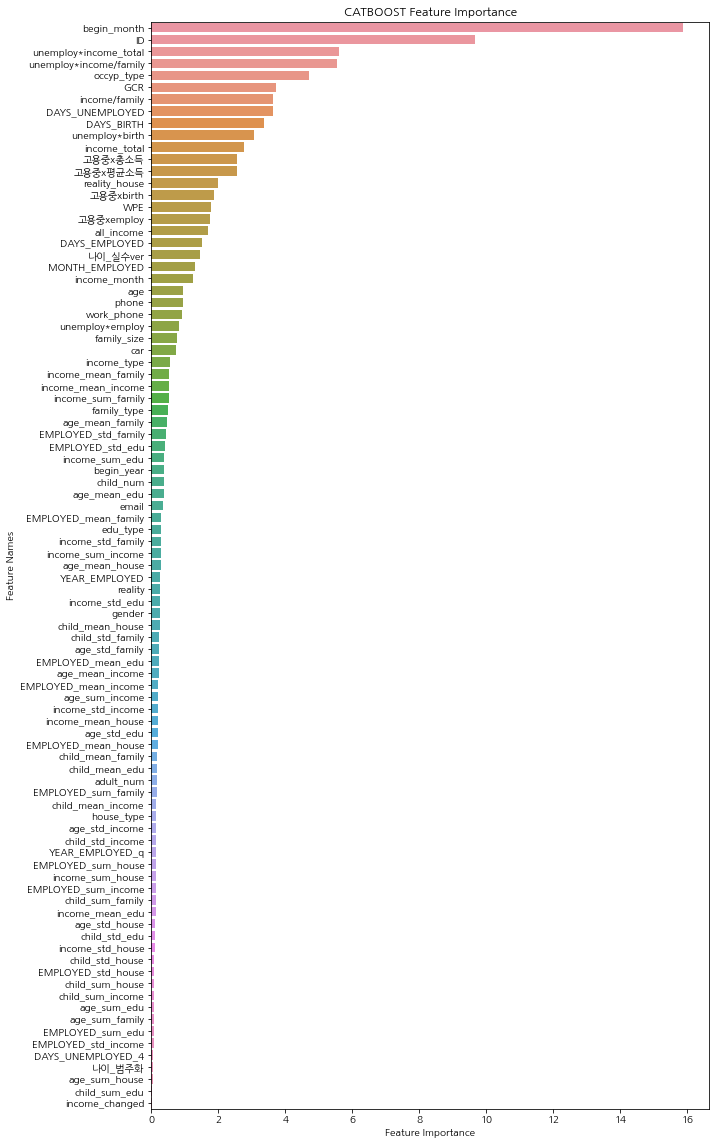

In [83]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,20))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plt.rcParams['font.family'] = 'NanumGothic'
plot_feature_importance(model.get_feature_importance(), test_X.columns, 'CATBOOST')